# Test for data analysis

This notebooks is used to analyse the distribution of kinetic energy and charge density of bunch electrons in a Laser Wakefield simulation.

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import openpmd_api as io
from scipy import constants
from scipy.optimize import curve_fit
import scipy.integrate as integrate

from matplotlib.colors import LogNorm, SymLogNorm, Normalize
from matplotlib.colors import hsv_to_rgb
from scipy import stats

In [ ]:
path="/bigdata/hplsim/production/wrobel45/PWFA-bunch-bachelor1/particles_250MeV/034_particles_bachelor1/simOutput/openPMD/simData_beta_%T.bp"
#path="/bigdata/hplsim/production/wrobel45/tinkering/index_test_h5/simOutput/openPMD/simData_%T.bp"

## Definitions

Define different functions for data fitting.

In [ ]:
# calculate width of window
y_cells = 2048
z_cells = 1024      # should be same as x_cells
y_gpus = 8
cellwidth = 0.5 * 0.1772e-6 * 1e6   # in micorometer, same for all directions
Delta_t = 1.706e-16/1.28631
windowwidth = y_cells * (y_gpus-1)/y_gpus * cellwidth
windowheight = z_cells * cellwidth

In [ ]:
def Gauss(x, a, b):
    y = 1/np.sqrt(2*np.pi * b**2) * np.exp(-(x-a)**2 / (2*b**2))
    return y

def Lorentz(x, a, b):
    y = 2/np.pi * b / (4*(x - a)**2 + b)
    return y

def Max_Boltz_2D(x, a):
    y = x/a * np.exp(-x**2 / (2*a))
    return y

In [ ]:
def particlePMD(particle, pos=True, mom=True, probeE=False, probeB=False, Id=False):
    """ Returns unpacked particle data from openPMD.
    Always returns weights, optionally returns position, momentum and the exerted E- and B-fields on the particles.
    Position is returned in \mu m, the rest in SI-units.
    """
    
    if pos:
        x_off = particle["positionOffset"]["x"][:]
        x_off_unit = particle["positionOffset"]["x"].unit_SI
        y_off = particle["positionOffset"]["y"][:]
        y_off_unit = particle["positionOffset"]["y"].unit_SI
        z_off = particle["positionOffset"]["z"][:]
        z_off_unit = particle["positionOffset"]["z"].unit_SI

        x = particle["position"]["x"][:]
        x_unit = particle["position"]["x"].unit_SI
        y = particle["position"]["y"][:]
        y_unit = particle["position"]["y"].unit_SI
        z = particle["position"]["z"][:]
        z_unit = particle["position"]["z"].unit_SI

    if mom:
        p_x = particle["momentum"]["x"][:]
        p_x_unit = particle["momentum"]["x"].unit_SI
        p_y = particle["momentum"]["y"][:]
        p_y_unit = particle["momentum"]["y"].unit_SI
        p_z = particle["momentum"]["z"][:]
        p_z_unit = particle["momentum"]["z"].unit_SI

    if probeE:
        x_probeE = particle['probeE']['x'][:]
        x_probeE_unit = particle["probeE"]["x"].unit_SI 
        y_probeE = particle['probeE']['y'][:]
        y_probeE_unit = particle["probeE"]["y"].unit_SI
        z_probeE = particle['probeE']['z'][:]
        z_probeE_unit = particle["probeE"]["z"].unit_SI

    if probeB:
        x_probeB = particle['probeB']['x'][:]
        x_probeB_unit = particle["probeB"]["x"].unit_SI 
        y_probeB = particle['probeB']['y'][:]
        y_probeB_unit = particle["probeB"]["y"].unit_SI
        z_probeB = particle['probeB']['z'][:]
        z_probeB_unit = particle["probeB"]["z"].unit_SI

    if Id:
        particleId = particle["id"][io.Mesh_Record_Component.SCALAR][:]

    weight = particle["weighting"][io.Mesh_Record_Component.SCALAR][:]

    series.flush()

    pack = [weight]

    if pos:
        x_pos = (x * x_unit + (x_off-512) * x_off_unit) * 1e6
        y_pos = (y * y_unit +  y_off      * y_off_unit) * 1e6
        z_pos = (z * z_unit + (z_off-512) * z_off_unit) * 1e6
        pack = np.append(pack, [x_pos, y_pos, z_pos], axis=0)

    if mom:
        x_mom = p_x * p_x_unit
        y_mom = p_y * p_y_unit
        z_mom = p_z * p_z_unit
        pack = np.append(pack, [x_mom, y_mom, z_mom], axis=0)

    if probeE:
        x_probeE *= x_probeE_unit
        y_probeE *= y_probeE_unit
        z_probeE *= z_probeE_unit
        pack = np.append(pack, [x_probeE, y_probeE, z_probeE], axis=0)

    if probeB:
        x_probeB *= x_probeB_unit
        y_probeB *= y_probeB_unit
        z_probeB *= z_probeB_unit
        pack = np.append(pack, [x_probeB, y_probeB, z_probeB], axis=0)

    if Id:
        pack = np.append(pack, [particleId], axis=0)

    return pack

In [ ]:
def mom_to_E(x_mom, y_mom, z_mom):
    # squared total momentum
    p2_total = np.float64(x_mom**2 + y_mom**2 + z_mom**2)
    # energy per macro particle in Joule
    E_J = (constants.c * np.sqrt((constants.m_e*weight)**2 * constants.c**2 + p2_total) - (constants.m_e*weight) * constants.c**2) * 1/weight
    # conversion to MeV
    E = E_J / constants.e / 1e6
    
    return E

In [ ]:
def binned_to_grid(bin_x, bin_y):
    """Transforms 2D bins into grid.
    The left borders of the bins are taken as gridpoints, the rightmost border is discarded.
    """
    x_width = bin_x[1] - bin_x[0]
    y_width = bin_y[1] - bin_y[0]
    x = bin_x[:-1] + x_width/2
    y = bin_y[:-1] + y_width/2
    
    return x, y

## openPMD

In [ ]:
# timestep at which data is evaluated
timestep = 0

In [ ]:
# file paths to openPMD data
#path_PMD = "/bigdata/hplsim/production/wrobel45/PWFA-bunch-runs/012_vacuum_prop_corrected/simOutput/checkpoints/checkpoint_000000.h5"
#path_PMD="/bigdata/hplsim/production/wrobel45/PWFA-bunch-runs/013_vacuum_prop_corrected/simOutput/openPMD/simData_beta_{:06d}.bp".format(timestep)
path_PMD="/bigdata/hplsim/production/wrobel45/PWFA-bunch-bachelor1/060_particles400_bachelor1/simOutput/openPMD/simData_%T.bp"
chunksize = 10**4                    # size of chunk to flush
bins = np.linspace(0, 0.4, 1000)              # bins for histogram

In [ ]:
def read_PMD(path, timestep, chunksize, bins):
    """
    """
    # start reading PMD data
    series = io.Series(path,
                       io.Access.read_only)
    electron = series.iterations[timestep].particles["b"]
    # factor to convert to SI units
    p_unit = electron["momentum"]["x"].unit_SI
    r_unit = electron["position"]["x"].unit_SI
    # number of macro particles
    size = electron["momentum"]["x"].shape[0]

    series.flush()

    hist_r_total = np.zeros(len(bins)-1)
    hist_div_total = np.zeros(len(bins)-1)
    # iterate over all macro particles in chunks
    for i in range(int(size/chunksize+0.5)):
        # weighting of each macro particle
        weight = electron["weighting"][io.Mesh_Record_Component.SCALAR][i*chunksize:(i+1)*chunksize]

        x = electron["position"]["x"][i*chunksize:(i+1)*chunksize]
        z = electron["position"]["z"][i*chunksize:(i+1)*chunksize]

        # momentum of the macro electrons
        p_x = electron["momentum"]["x"][i*chunksize:(i+1)*chunksize]
        p_y = electron["momentum"]["y"][i*chunksize:(i+1)*chunksize]
        p_z = electron["momentum"]["z"][i*chunksize:(i+1)*chunksize]

        series.flush()

        # trying to evade floating point errors
        weight = np.float64(weight)
        r = np.sqrt(x**2 + z**2) * r_unit
        r_div = np.sqrt(p_x**2 + p_z**2) / p_y

        # adding up histograms, var can be dismisses
        # right bin border must be included
        hist_r_local, var = np.histogram(r, bins/1e6, weights=weight)
        hist_div_local, var = np.histogram(r_div, bins, weights=weight)

        hist_r_total += hist_r_local
        hist_div_total += hist_div_local
        
    del series
    
    return hist_r_total, hist_div_total

In [ ]:
hist_r_total, hist_div_total = read_PMD(path_PMD, timestep, chunksize, bins)
# plot histogram
plt.bar(bins[:-1]/1e6, hist_r_total, log=True, align='edge', width=1e-9)
plt.xlabel("r [m]")
plt.ylabel("count")
#plt.title("timestep: {:1d}".format(timestep))
plt.show()

plt.bar(bins[:-1], hist_div_total, log=True, align='edge', width=1e-3)

plt.xlabel("div")
plt.ylabel("count")
#plt.title("timestep: {:1d}".format(timestep))
plt.show()

## Density fields

Plots the charge- and energy-density fields for b- and e-Particles

e_field_charge:  0.0 0.0
e_field_energy:  0.0 0.0
b_field_charge:  -1.0340044 0.0
b_field_energy:  0.0 494.2146


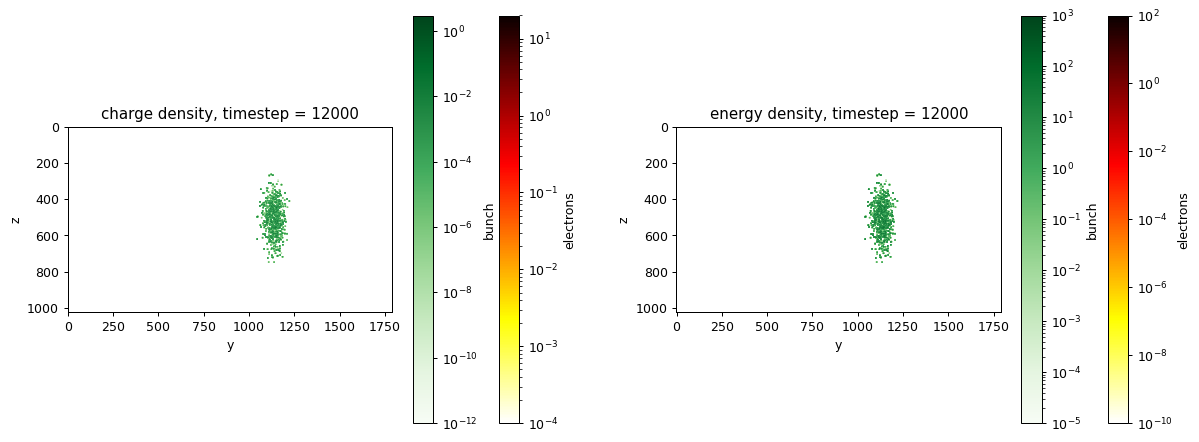

e_field_charge:  -0.32524365 0.0
e_field_energy:  0.0 0.057604097
b_field_charge:  -0.89452684 0.0
b_field_energy:  0.0 439.01196


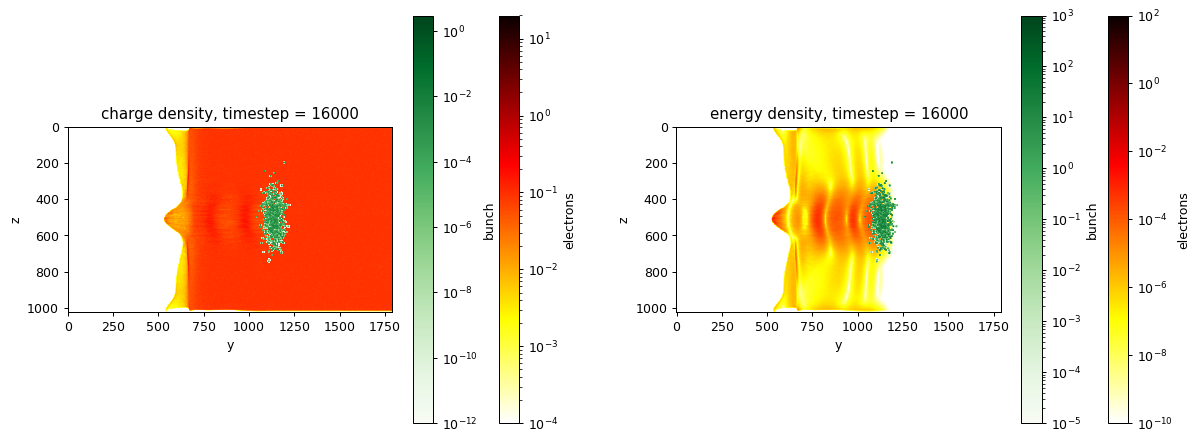

e_field_charge:  -0.38573185 0.0
e_field_energy:  0.0 0.040641595
b_field_charge:  -1.0146326 0.0
b_field_energy:  0.0 471.1505


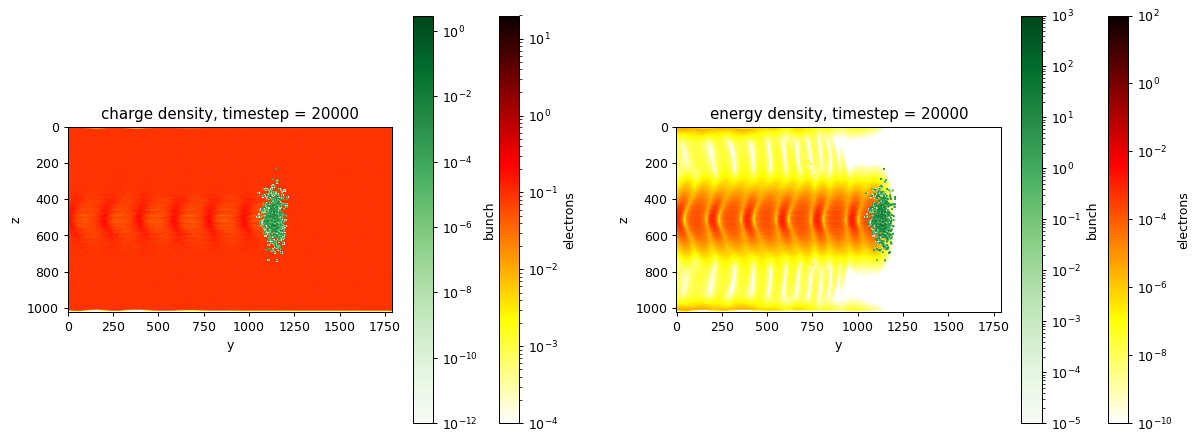

In [8]:
# Test for density plots
series = io.Series(path, io.Access.read_only)

for i in range(12000, 20000+1, 4000):
    plt.figure(figsize=(16, 6), dpi=90)
    e_field_charge = series.iterations[i].meshes["e_all_chargeDensity"][io.Mesh_Record_Component.SCALAR][:,:,512]
    e_field_energy = series.iterations[i].meshes["e_all_energyDensity"][io.Mesh_Record_Component.SCALAR][:,:,512]
    b_field_charge = series.iterations[i].meshes["b_all_chargeDensity"][io.Mesh_Record_Component.SCALAR][:,:,512]
    b_field_energy = series.iterations[i].meshes["b_all_energyDensity"][io.Mesh_Record_Component.SCALAR][:,:,512]
    series.flush()
    
    print("e_field_charge: ", np.min(e_field_charge), np.max(e_field_charge))
    print("e_field_energy: ", np.min(e_field_energy), np.max(e_field_energy))
    print("b_field_charge: ", np.min(b_field_charge), np.max(b_field_charge))
    print("b_field_energy: ", np.min(b_field_energy), np.max(b_field_energy))
    
    plt.subplot(121)
    plt.imshow(-e_field_charge, cmap='hot_r', norm=LogNorm(vmin=1e-4, vmax=20))
    plt.colorbar(label="electrons")    
    plt.imshow(-b_field_charge, cmap='Greens', norm=LogNorm(vmin=1e-12, vmax=3))
    plt.colorbar(label="bunch") 
    plt.xlabel("y")
    plt.ylabel("z")
    plt.title("charge density, timestep = {}".format(i))
    
    plt.subplot(122)
    plt.imshow(e_field_energy, cmap='hot_r', norm=LogNorm(vmin=1e-10, vmax=1e2))
    plt.colorbar(label="electrons")    
    plt.imshow(b_field_energy, cmap='Greens', norm=LogNorm(vmin=1e-5, vmax=1e3))
    plt.colorbar(label="bunch")    
    plt.xlabel("y")
    plt.ylabel("z")
    plt.title("energy density, timestep = {}".format(i))
    
    plt.show()
    #plt.savefig(fname="temp", facecolor="white")

del series

# gibt es transparente Farbschemen?

## Phasespace

Plots the y-p_y (or other combinations) phase space.

In [ ]:
series = io.Series(path, io.Access.read_only)

for t in range(60000, 90000+1, 1000):
    particle = series.iterations[t].particles["b_all"]

    weight, x_pos, y_pos, z_pos, x_mom, y_mom, z_mom = particlePMD(particle)

    # phase histogram
    plt.figure(figsize=(8, 6), dpi=90)
    plt.hist2d(y_pos, y_mom, bins=200, weights=weight, cmap="hot_r")
    plt.colorbar()
    plt.xlabel("$y \, \mathrm{[\mu m]}$")
    plt.ylabel("$p_y\, \mathrm{[Ns]}$")
    plt.title("y-p_y-phase space, timestep = {}".format(t))
    plt.show()
    #plt.savefig('temp.png', facecolor='w')

del series

## ???

x-Position

In [ ]:
ydata, bins, temp = plt.hist(x_pos, bins=500, weights=weight, label='data', density=True)

# change x to middle of the bins
width = bins[1] - bins[0]
xdata = bins[:-1] + width/2
# start parameters for fit
p0 = [0, 7]

parameters, covariance = curve_fit(Gauss, xdata, ydata, p0)
fit_a = parameters[0]
fit_b = parameters[1]
  
fit_y = Gauss(xdata, fit_a, fit_b)
plt.plot(xdata, fit_y, '-', label='fit')

plt.xlabel("x [\mu m]")
plt.ylabel("density")
plt.title("particle density x")
plt.legend()
plt.show()
print("Mean: {:.4f} \nStd.-Dev.: {:.4f}".format(fit_a, fit_b))

y-Position

In [ ]:
ydata, bins, temp = plt.hist(y_pos, bins=500, weights=weight, label='data', density=True)

# change x to middle of the bins
width = bins[1] - bins[0]
xdata = bins[:-1] + width/2
# start parameters for fit
p0 = [100, 2]

parameters, covariance = curve_fit(Gauss, xdata, ydata, p0)
fit_a = parameters[0]
fit_b = parameters[1]
  
fit_y = Gauss(xdata, fit_a, fit_b)
plt.plot(xdata, fit_y, '-', label='fit')

plt.xlabel("y [\mu m]")
plt.ylabel("density")
plt.title("particle density y")
plt.legend()
plt.show()
print("Mean: {:.4f} \nStd.-Dev.: {:.4f}".format(fit_a, fit_b))

z-Position

In [ ]:
ydata, bins, temp = plt.hist(z_pos, bins=500, weights=weight, label='data', density=True)

# change x to middle of the bins
width = bins[1] - bins[0]
xdata = bins[:-1] + width/2
# start parameters for fit
p0 = [0, 7]

parameters, covariance = curve_fit(Gauss, xdata, ydata, p0)
fit_a = parameters[0]
fit_b = parameters[1]
  
fit_y = Gauss(xdata, fit_a, fit_b)
plt.plot(xdata, fit_y, '-', label='fit')

plt.xlabel("z [\mu m]")
plt.ylabel("density")
plt.title("particle density z")
plt.legend()
plt.show()
print("Mean: {:.4f} \nStd.-Dev.: {:.4f}".format(fit_a, fit_b))

In [ ]:
# div?

ydata, bins, temp = plt.hist(p_y, bins=500, weights=weight, label='data', density=True)

# change x to middle of the bins
width = bins[1] - bins[0]
xdata = bins[:-1] + width/2
# start parameters for fit
p0 = [50, 1]

parameters, covariance = curve_fit(Gauss, xdata, ydata, p0)
fit_a = parameters[0]
fit_b = parameters[1]
  
fit_y = Gauss(xdata, fit_a, fit_b)
plt.plot(xdata, fit_y, '-', label='fit')
plt.xlabel("div [mrad]")
plt.ylabel("density")
plt.legend()
plt.show()
print("Mean: {:.4e} \nStd.-Dev.: {:.4f}".format(fit_a, fit_b))

In [ ]:
# total positions in micrometer
x_pos = (x * x_unit + (x_off-512) * x_off_unit) * 1e6
y_pos = (y * y_unit +  y_off      * y_off_unit) * 1e6
z_pos = (z * z_unit + (z_off-512) * z_off_unit) * 1e6

# should be sqrt(x**2+z**2, but this isn't Gaussian)
r = np.sqrt(x_pos**2 + z_pos**2)

r_div = np.arctan2(p_x, p_y)

ydata, bins, temp = plt.hist(r, bins=500, weights=weight, label='data', density=True)

# change x to middle of the bins
width = bins[1] - bins[0]
xdata = bins[:-1] + width/2

#fitting the data
parameters, covariance = curve_fit(Max_Boltz_2D, xdata, ydata)
fit_a = parameters[0]
  
fit_y = Max_Boltz_2D(xdata, fit_a)
plt.plot(xdata, fit_y, '-', label='fit')

plt.xlabel("r [\mu m]")
plt.ylabel("density")
plt.legend()
plt.show()

mean = np.sqrt(fit_a * np.pi/2)
Var = 2*fit_a - mean**2
print("Mean: {:.4f} \nVar: {:.4f}".format(mean, Var))


ydata, bins, temp = plt.hist(r_div, bins=500, weights=weight, label='data', density=True)

# change x to middle of the bins
width = bins[1] - bins[0]
xdata = bins[:-1] + width/2

parameters, covariance = curve_fit(Max_Boltz_2D, xdata, ydata)
fit_a = parameters[0]
  
fit_y = Max_Boltz_2D(xdata, fit_a)
plt.plot(xdata, fit_y, '-', label='fit')
plt.xlabel("div")
plt.ylabel("density")
plt.legend()
plt.show()

mean = np.sqrt(fit_a * np.pi/2)
Var = 2*fit_a - mean**2
print("Mean: {:.4e} \nVar: {:.4e}".format(mean, Var))

In [ ]:
path_Phase = "/bigdata/hplsim/production/wrobel45/PWFA-bunch-runs/013_vacuum_prop_corrected/simOutput/phaseSpace/PhaseSpace_b_all_xpy_500.bp"

In [ ]:
series = io.Series(path_Phase,
                    io.Access.read_only)

image = series.iterations[500].meshes["b_all_xpy"][io.Mesh_Record_Component.SCALAR][:]
series.flush()
del series
# missing unit factor
plt.imshow(image)
plt.show()

In [ ]:
m = 4
x = np.linspace(0, 50, 400)
y = Max_Boltz_2D(x, m)
plt.plot(x,y)
z = [integrate.quad(Max_Boltz_2D, 0, 50, args=(m))[0] for m in np.linspace(0,100, 100)]
plt.plot(z)

In [ ]:
path = "/bigdata/hplsim/production/wrobel45/PWFA-bunch-runs/013_vacuum_prop_corrected/simOutput/openPMD/simData_%T.bp"

series = io.Series(path, io.Access.read_only)
fields = series.iterations[1000].meshes["E"].get_attribute("gridGlobalOffset")
print(fields)


In [ ]:
path = "/bigdata/hplsim/production/wrobel45/PWFA-bunch-bachelor1/060_particles400_bachelor1/b_energy_all"
print(path)

## Energy-Histograms

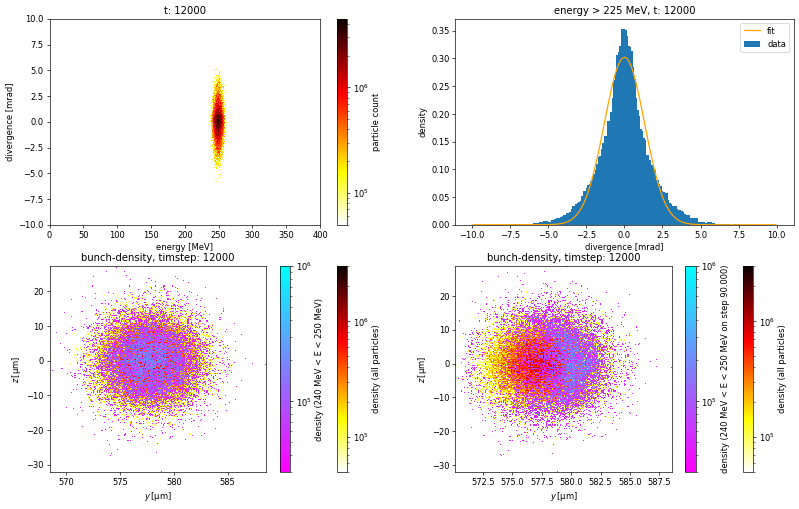

249.8


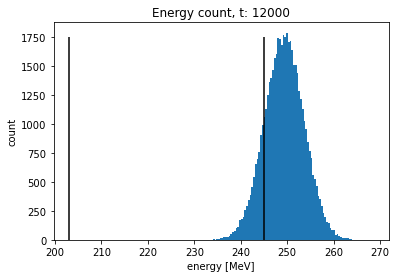

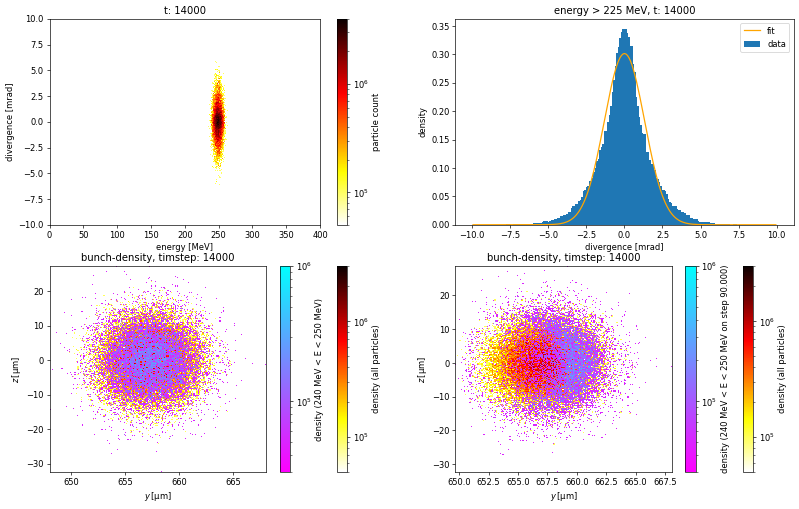

249.0


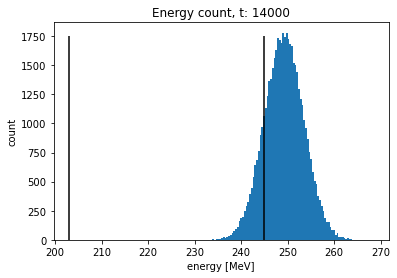

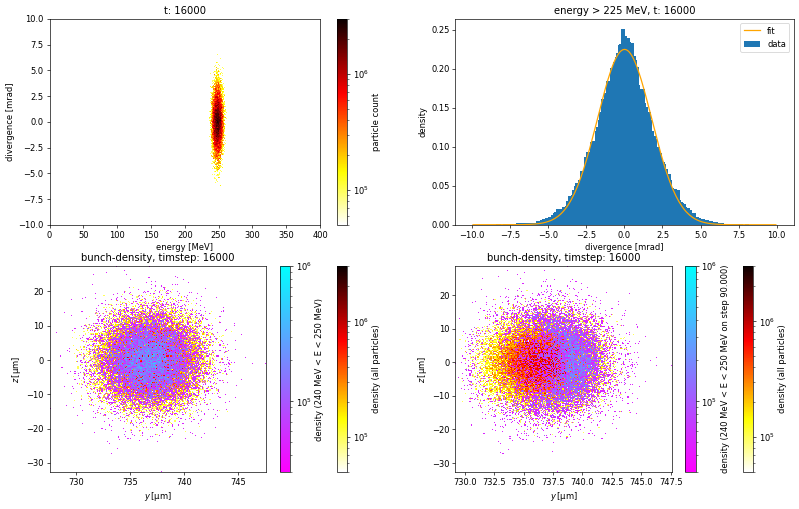

249.0


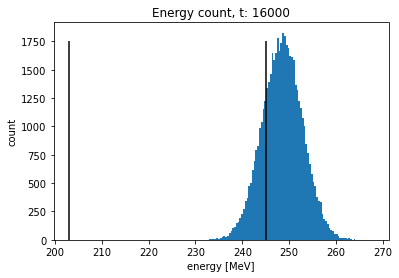

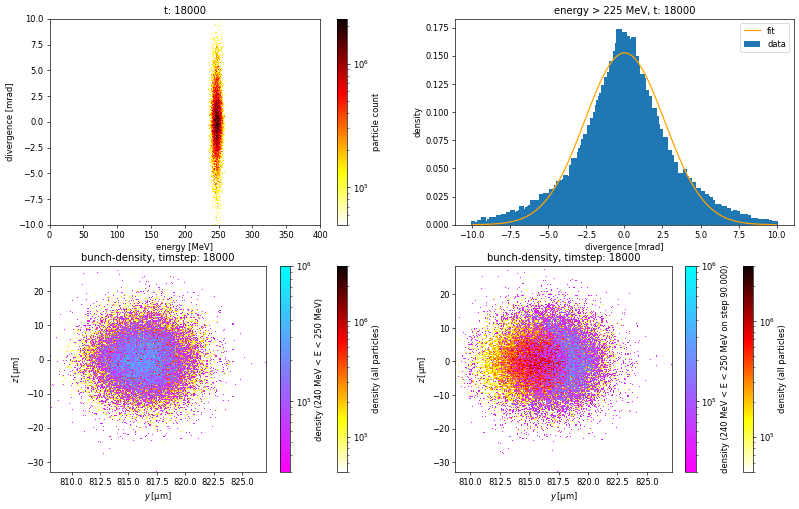

247.0


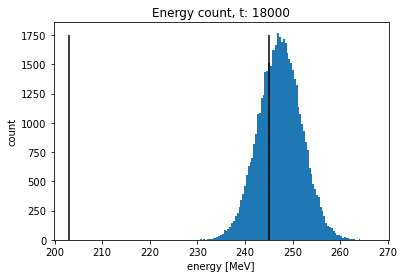

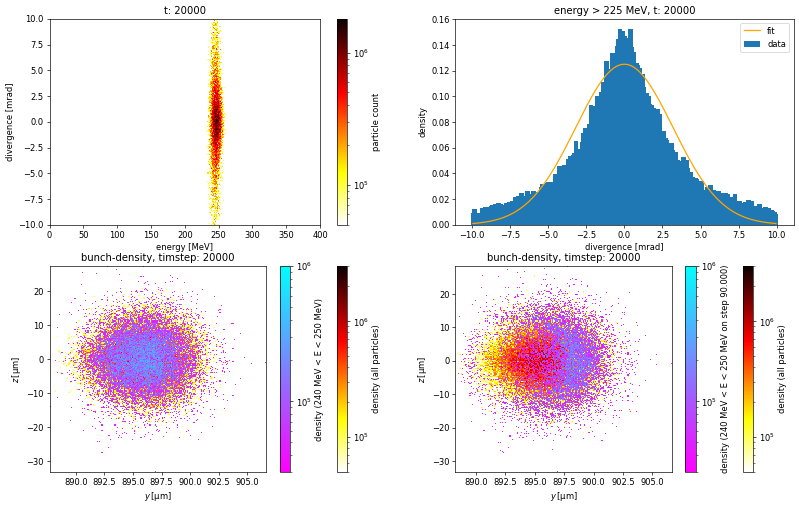

247.0


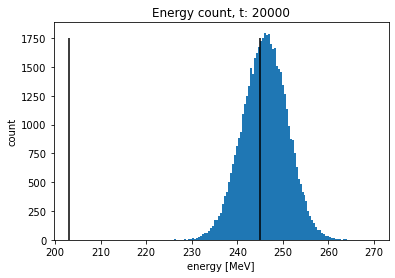

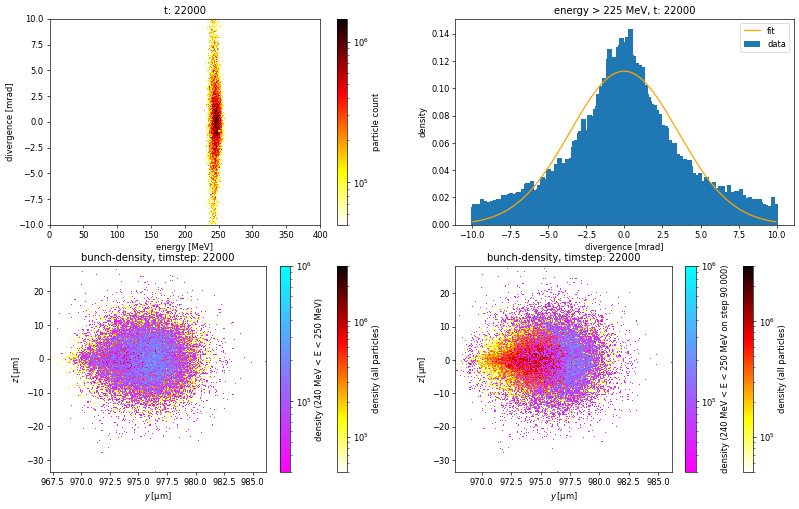

245.4


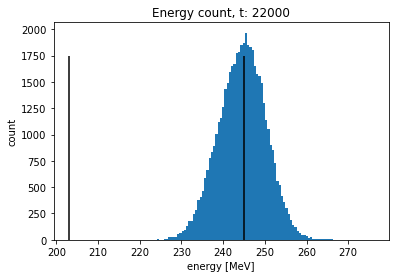

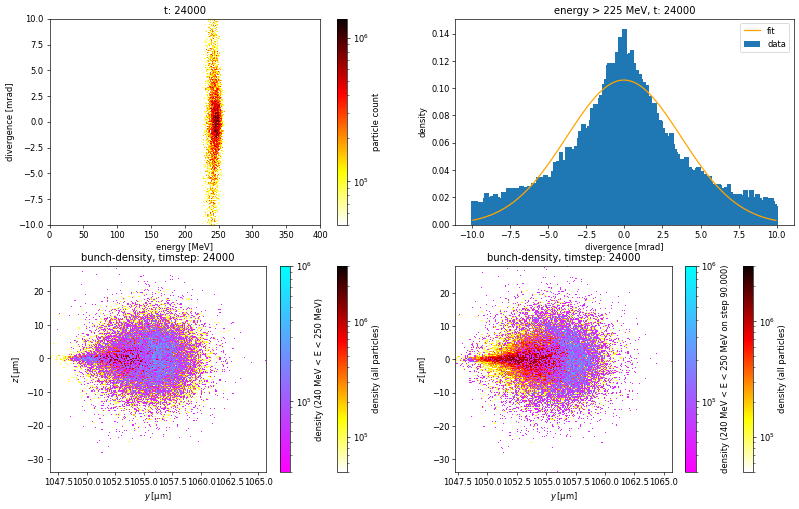

244.6


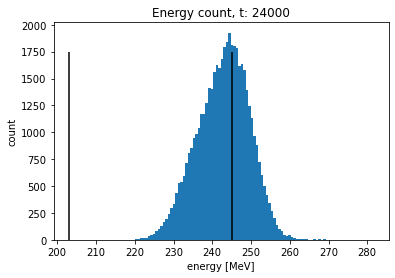

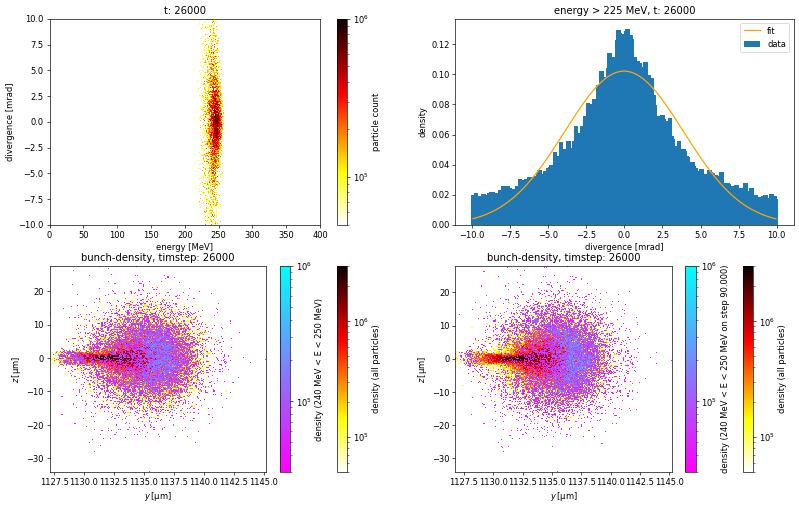

245.4


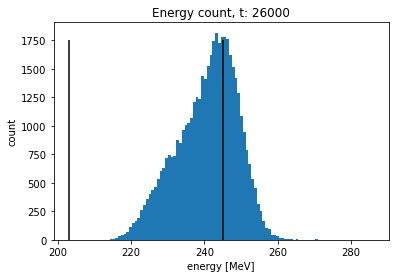

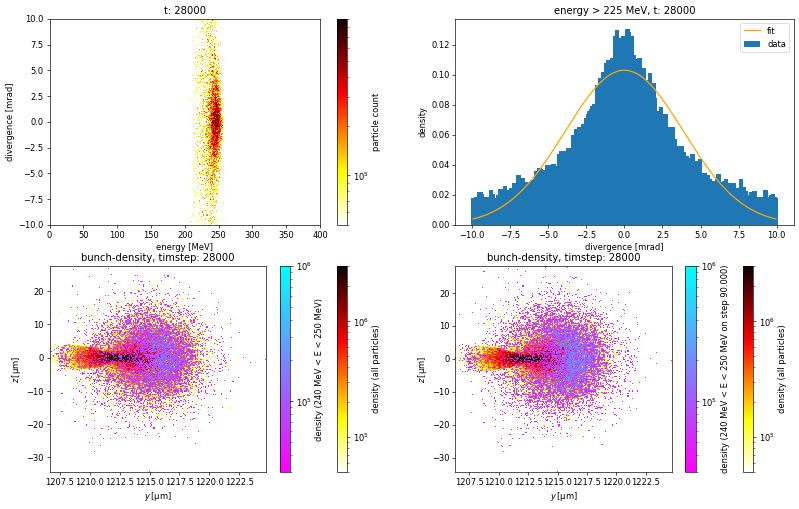

245.8


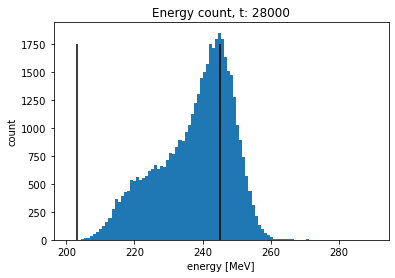

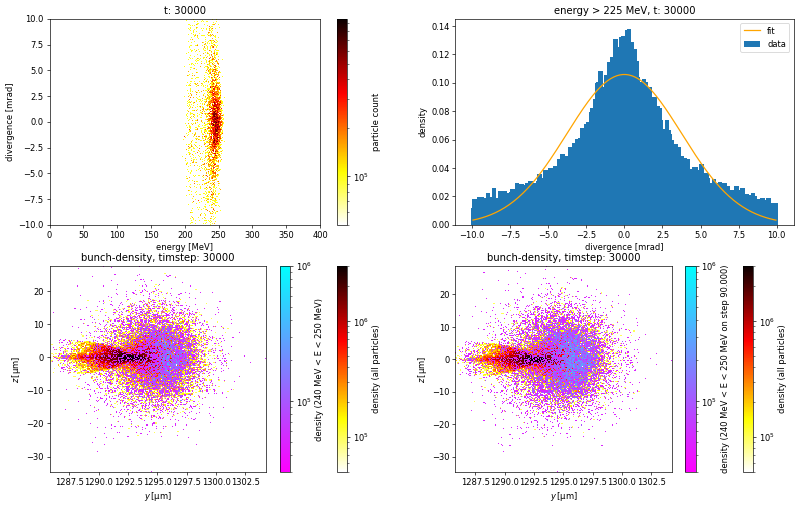

244.6


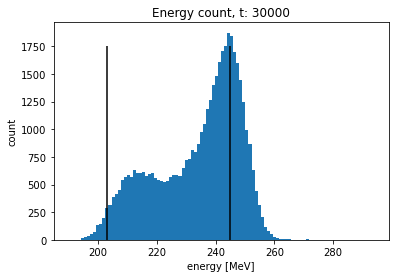

In [11]:
time = range(12000, 30000+1, 2000)
E_bins = 100                    # Bin number for energy histogram
peak_energy = 245               # peak energy for masks
max_Energy = 0                  # maximum energy, should be automatically set

E_peak = np.zeros(len(time))
E_peak2 = np.zeros(len(time))
E_max = np.zeros(len(time))
E_min = np.zeros(len(time))
E_mean = np.zeros(len(time))
E_std = np.zeros(len(time))
# stores Energy histogram for every timestep
E_hist = np.zeros((len(time), E_bins))

# start reading openPMD data
series = io.Series(path, io.Access.read_only)

# return id's of particles, which have peak energy at the last timestep
particle = series.iterations[30000].particles["b_all"]
weight, x_mom, y_mom, z_mom, particleId = particlePMD(particle, pos=False, Id=True)

E = mom_to_E(x_mom, y_mom, z_mom)
max_Energy = np.max(E) + 5
id_peak = particleId[(E>peak_energy-3)&(E<peak_energy+3)]

for i, t in enumerate(time):
    particle = series.iterations[t].particles["b_all"]
    weight, x_pos, y_pos, z_pos, x_mom, y_mom, z_mom, particleId = particlePMD(particle, Id=True)

    E = mom_to_E(x_mom, y_mom, z_mom)

    E_max[i] = np.max(E)
    E_min[i] = np.min(E)
    E_mean[i] = np.mean(E)
    E_std[i] = np.std(E)
    E_hist[i][:] = np.histogram(E, bins=E_bins, range=(0, max_Energy))[0]

    # divergence
    div = np.arctan2(x_mom, y_mom)*1e3
    
    # plots
    plt.figure(figsize=(16, 10), dpi=60)
    
    # energy-divergence plot
    plt.subplot(221)
    plt.xlabel("energy [MeV]")
    plt.ylabel("divergence [mrad]")
    plt.title("t: {:1d}".format(t))
    hist = plt.hist2d(E, div, weights=weight, bins=[1000, 201], cmap="hot_r", norm=LogNorm(), range=[[0, 400], [-10, 10]])   
    plt.colorbar(label="particle count")

    # calculates index of given energy when changing the xbins or xrange
    xstart = int(225 / 400 * 1000)
    # density histogram summed over energys above 225 MeV
    xdata = hist[2][:-1]
    xwidth = xdata[1] - xdata[0]
    xdata += xwidth/2
    ydata = np.sum(hist[0][xstart:,:], axis=0) / (np.sum(hist[0][xstart:,:]) * xwidth)
    
    # fitting to Gauss curve
    p0 = [0, 3]
    parameters, covariance = curve_fit(Gauss, xdata, ydata, p0)
    fit_a = parameters[0]
    fit_b = parameters[1]
    fit_y = Gauss(xdata, fit_a, fit_b)
    
    plt.subplot(222)
    plt.bar(xdata, ydata, label='data',width=0.3)
    plt.plot(xdata, fit_y, label='fit', c='orange')
    plt.xlabel("divergence [mrad]")
    plt.ylabel("density")
    plt.title("energy > 225 MeV, t: {:1d}".format(t))
    plt.legend()

    # shows only particles with E in given intervall
    E_mask = (E>peak_energy-2)&(E<peak_energy+2)
    id_mask = np.isin(particleId, id_peak)
    
    y_peak = y_pos[E_mask]
    z_peak = z_pos[E_mask]
    weight_peak = weight[E_mask]
    
    y_id_peak = y_pos[id_mask]
    z_id_peak = z_pos[id_mask]
    weight_id_peak = weight[id_mask]
    
    # particle density plot where particles with peak density are highlighted
    plt.subplot(223)
    plt.hist2d(y_pos, z_pos, bins=200,  weights=weight, cmap='hot_r', norm=LogNorm(vmin=5e4, vmax=3e6))
    plt.colorbar(label='density (all particles)')
    plt.hist2d(y_peak, z_peak, bins=200,  weights=weight_peak, cmap='cool_r', norm=LogNorm(vmin=3e4, vmax=1e6))
    plt.colorbar(label='density (240 MeV < E < 250 MeV)')
    plt.xlabel("$y \, \mathrm{[\mu m]}$")
    plt.ylabel("$z \, \mathrm{[\mu m]}$")
    plt.title("bunch-density, timstep: {:1d}".format(t))    
    
    # particle density plot where particles with peak density at step 90.000 are highlighted
    plt.subplot(224)
    plt.hist2d(y_pos, z_pos, bins=200,  weights=weight, cmap='hot_r', norm=LogNorm(vmin=5e4, vmax=3e6))
    plt.colorbar(label='density (all particles)')
    plt.hist2d(y_id_peak, z_id_peak, bins=200,  weights=weight_id_peak, cmap='cool_r', norm=LogNorm(vmin=3e4, vmax=1e6))
    plt.colorbar(label='density (240 MeV < E < 250 MeV on step 90.000)')
    plt.xlabel("$y \, \mathrm{[\mu m]}$")
    plt.ylabel("$z \, \mathrm{[\mu m]}$")
    plt.title("bunch-density, timstep: {:1d}".format(t))   
    plt.show()    

    # Peak energies
    xdata = hist[1][:-1]
    xwidth = xdata[1] - xdata[0]
    xdata += xwidth/2
    ydata = np.sum(hist[0], axis=1)   
    E_peak[i] = xdata[np.argmax(ydata)]
    E_peak2[i] = xdata[np.argmax(ydata[xdata<180])]

    print(E_peak[i])

#    plt.subplot(223)
    plt.hist(E[(div<20)&(div>-20)], bins=E_bins)
    plt.xlabel("energy [MeV]")
    plt.ylabel("count")
    plt.title("Energy count, t: {:1d}".format(t))
    plt.vlines(peak_energy, 0, 1750, color='black')
    plt.vlines(203, 0, 1750, color='black')

    #plt.savefig(fname="temp", facecolor="white")
    plt.show()    

del series

NameError: name 'E_hist' is not defined

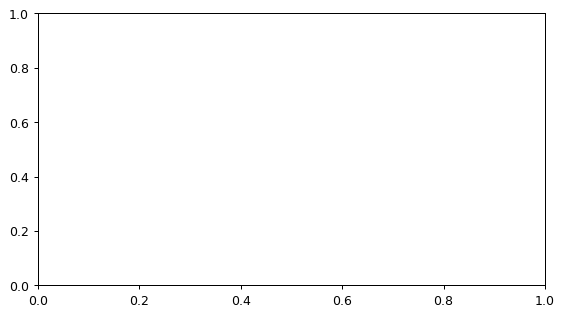

In [34]:
plt.figure(figsize=(16, 4), dpi=90)

plt.subplot(121)
plt.imshow(E_hist.T, origin='lower', extent=(time[0]-1e3, time[-1]+1e3, 0, max_Energy), aspect='auto', interpolation='none')
plt.plot(time, E_max, marker='.', label='E_max')
plt.errorbar(time, E_mean, yerr=E_std, marker='.', label='E_mean', capsize=3)
plt.plot(time, E_peak, marker='.', label='E_peak', c='red')
plt.plot(time, E_min, marker='.', label='E_min')
plt.colorbar(label='particle count')
plt.xlabel("timestep")
plt.ylabel("energy [MeV]")
plt.title("energy over time")
plt.legend()

plt.subplot(122)
plt.plot(time, E_peak, marker='.', lw=0)
plt.hlines(np.mean(E_peak), time[0], time[-1], color='black')
plt.xlabel("timestep")
plt.ylabel("energy [MeV]")
plt.title("peak energy over time")

plt.show()
#plt.savefig(fname="temp", facecolor="white", dpi=100)

## Position density and Fields

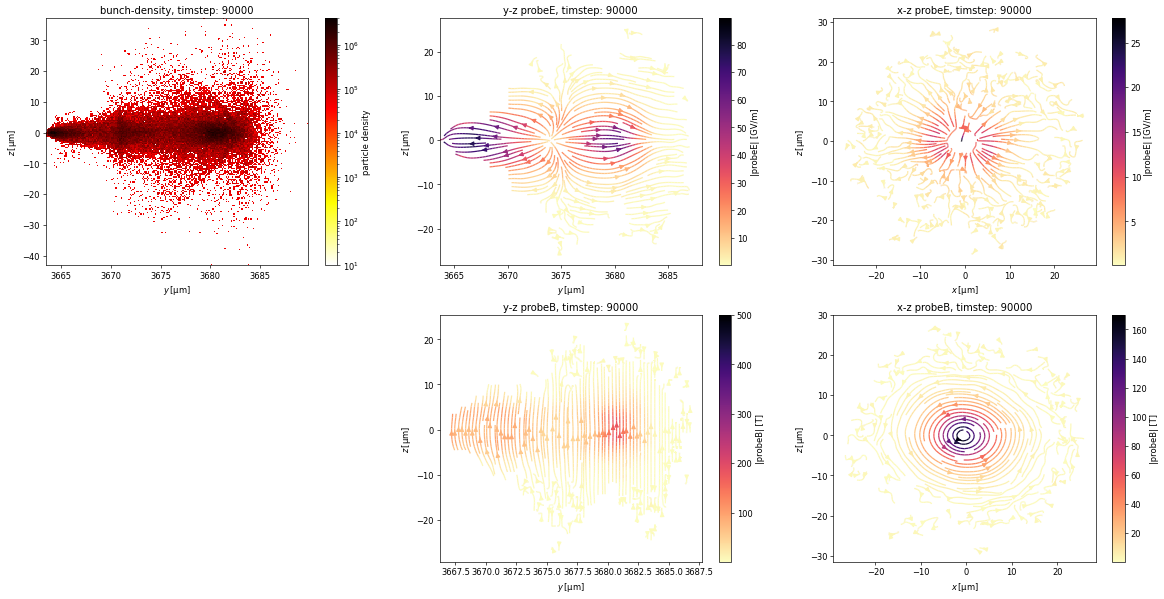

In [46]:
series = io.Series(path, io.Access.read_only)
time = range(90000, 90000+1, 2000)

for i, t in enumerate(time):
    particle = series.iterations[t].particles["b_all"]
    
    weight, x_pos, y_pos, z_pos, x_probeE, y_probeE, z_probeE, x_probeB, y_probeB, z_probeB = particlePMD(particle, mom=False, probeE=True, probeB=True)

    plt.figure(dpi=60, figsize=(24, 12))
    plt.subplot(231)
    plt.hist2d(y_pos, z_pos, bins=200,  weights=weight, cmap='hot_r', norm=LogNorm())
    plt.colorbar(label='particle density')
    plt.xlabel("$y \, \mathrm{[\mu m]}$")
    plt.ylabel("$z \, \mathrm{[\mu m]}$")
    plt.title("bunch-density, timstep: {:1d}".format(t))
    
    statistic_E, bin_y_E, bin_z_E, rest_E = stats.binned_statistic_2d(y_pos, z_pos, (x_probeE*1e-9, y_probeE*1e-9, z_probeE*1e-9), statistic='mean', bins=60)
    y_E, z_E = binned_to_grid(bin_y_E, bin_z_E)
    abs_E = np.sqrt(statistic_E[0].T**2 + statistic_E[1].T**2 + statistic_E[2].T**2)
    
    plt.subplot(232)
    plt.streamplot(y_E, z_E, statistic_E[1].T, statistic_E[2].T, density=3, color=abs_E, cmap='magma_r')
    plt.colorbar(label='|probeE| [GV/m]')
    plt.xlabel("$y \, \mathrm{[\mu m]}$")
    plt.ylabel("$z \, \mathrm{[\mu m]}$")
    plt.title("y-z probeE, timstep: {:1d}".format(t))
    
    statistic_E, bin_x_E, bin_z_E, rest_E = stats.binned_statistic_2d(x_pos, z_pos, (x_probeE*1e-9, y_probeE*1e-9, z_probeE*1e-9), statistic='mean', bins=60)
    x_E, z_E = binned_to_grid(bin_x_E, bin_z_E)
    abs_E = np.sqrt(statistic_E[0].T**2 + statistic_E[1].T**2 + statistic_E[2].T**2)
    
    plt.subplot(233)
    plt.streamplot(x_E, z_E, statistic_E[0].T, statistic_E[2].T, density=3, color=abs_E, cmap='magma_r')
    plt.colorbar(label='|probeE| [GV/m]')
    plt.xlabel("$x \, \mathrm{[\mu m]}$")
    plt.ylabel("$z \, \mathrm{[\mu m]}$")
    plt.title("x-z probeE, timstep: {:1d}".format(t))
    
    probe_B_mask = (x_pos>0)
    statistic_B, bin_y_B, bin_z_B, rest_B = stats.binned_statistic_2d(y_pos[probe_B_mask], z_pos[probe_B_mask], (x_probeB[probe_B_mask], y_probeB[probe_B_mask], z_probeB[probe_B_mask]), statistic='mean', bins=60)
    y_B, z_B = binned_to_grid(bin_y_B, bin_z_B)
    abs_B = np.sqrt(statistic_B[0].T**2 + statistic_B[1].T**2 + statistic_B[2].T**2)
    
    plt.subplot(235)
    plt.streamplot(y_B, z_B, statistic_B[1].T, statistic_B[2].T, density=3, color=abs_B, cmap='magma_r')
    plt.colorbar(label='|probeB| [T]')
    plt.xlabel("$y \, \mathrm{[\mu m]}$")
    plt.ylabel("$z \, \mathrm{[\mu m]}$")
    plt.title("y-z probeB, timstep: {:1d}".format(t))
    
    statistic_B, bin_x_B, bin_z_B, rest_B = stats.binned_statistic_2d(x_pos, z_pos, (x_probeB, y_probeB, z_probeB), statistic='mean', bins=60)
    x_B, z_B = binned_to_grid(bin_x_B, bin_z_B)
    abs_B = np.sqrt(statistic_B[0].T**2 + statistic_B[1].T**2 + statistic_B[2].T**2)
                    
    plt.subplot(236)
    plt.streamplot(x_B, z_B, statistic_B[0].T, statistic_B[2].T, density=3, color=abs_B, cmap='magma_r')
    plt.colorbar(label='|probeB| [T]')
    plt.xlabel("$x \, \mathrm{[\mu m]}$")
    plt.ylabel("$z \, \mathrm{[\mu m]}$")
    plt.title("x-z probeB, timstep: {:1d}".format(t))
    
    plt.show()
#    plt.savefig(fname="temp", facecolor="white", dpi=300)
del series

In [ ]:
series = io.Series(path, io.Access.read_only)
time = range(4000, 40000+1, 2000)
div_x_mean = np.zeros(len(time))
div_z_mean = np.zeros(len(time))


for i, t in enumerate(time):
    particle = series.iterations[t].particles["b_all"]
    
    weight, x_mom, y_mom, z_mom= particlePMD(particle, pos=False)
    div_x_mean[i] = np.std(np.arctan2(x_mom, y_mom))*1e3
    div_z_mean[i] = np.std(np.arctan2(z_mom, y_mom))*1e3

del series
plt.plot(time, div_x_mean, label='x', marker='.')
plt.plot(time, div_z_mean, label='z', marker='.')
plt.xlabel("timestep")
plt.ylabel("$divergence \, \mathrm{[mrad]}$")
plt.legend()
plt.savefig(fname="temp", facecolor="white", dpi=100)

## Lorentz-Force

-0.0023349064410517427 -0.8077914523450015 -0.0013423676250238683


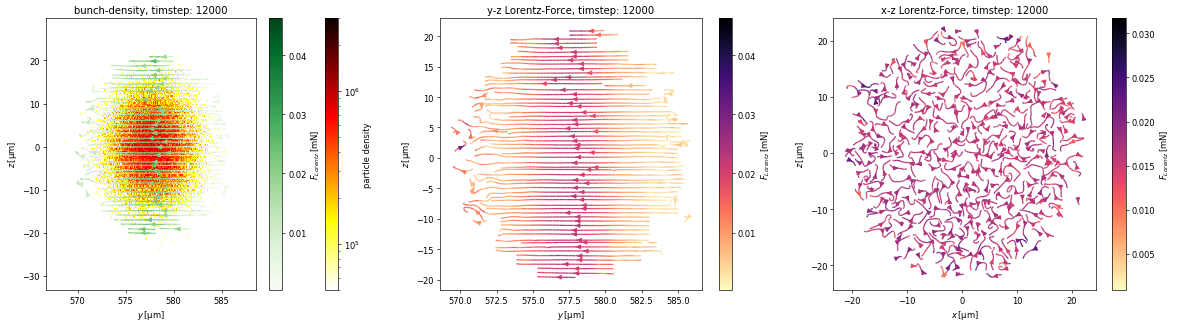

IndexError: Key '13000' does not exist (read-only).

In [ ]:
series = io.Series(path, io.Access.read_only)
time = range(12000, 30000+1, 1000)

for i, t in enumerate(time):
    particle = series.iterations[t].particles["b_all"]
    
    weight, x_pos, y_pos, z_pos, x_mom, y_mom, z_mom, x_probeE, y_probeE, z_probeE, x_probeB, y_probeB, z_probeB = particlePMD(particle, probeE=True, probeB=True)

    # converting momenta to velocity
    x_vel = np.sqrt((x_mom / (constants.m_e*weight))**2 / (1 + (x_mom**2 + y_mom**2 +z_mom**2) / (constants.m_e*weight)**2 / constants.c**2))
    y_vel = np.sqrt((y_mom / (constants.m_e*weight))**2 / (1 + (x_mom**2 + y_mom**2 +z_mom**2) / (constants.m_e*weight)**2 / constants.c**2))
    z_vel = np.sqrt((z_mom / (constants.m_e*weight))**2 / (1 + (x_mom**2 + y_mom**2 +z_mom**2) / (constants.m_e*weight)**2 / constants.c**2))

    F_x_B = y_vel*z_probeB - z_vel*y_probeB
    F_y_B = z_vel*x_probeB - x_vel*z_probeB
    F_z_B = x_vel*y_probeB - y_vel*x_probeB
    
    F_x_L = -constants.e*weight * (x_probeE + F_x_B)
    F_y_L = -constants.e*weight * (y_probeE + F_y_B)
    F_z_L = -constants.e*weight * (z_probeE + F_z_B)
    print(np.sum(F_x_L), np.sum(F_y_L),np.sum(F_z_L))
    statistic, bin_y, bin_z, rest = stats.binned_statistic_2d(y_pos, z_pos, (F_x_L, F_y_L, F_z_L), statistic='mean', bins=60)
    y, z = binned_to_grid(bin_y, bin_z)
    col = np.sqrt(statistic[0].T**2 + statistic[1].T**2 + statistic[2].T**2)*1e3
    
    plt.figure(dpi=60, figsize=(24, 6))
    plt.subplot(131)
    plt.hist2d(y_pos, z_pos, bins=200,  weights=weight, cmap='hot_r', norm=LogNorm())
    plt.colorbar(label='particle density')
    plt.streamplot(y, z, statistic[1].T, statistic[2].T, density=2, color=col, cmap='Greens')
    plt.colorbar(label='$F_{Lorentz} \, \mathrm{[mN]}$')
    plt.xlabel("$y \, \mathrm{[\mu m]}$")
    plt.ylabel("$z \, \mathrm{[\mu m]}$")
    plt.title("bunch-density, timstep: {:1d}".format(t))
    
    plt.subplot(132)
    plt.streamplot(y, z, statistic[1].T, statistic[2].T, density=3, color=col, cmap='magma_r')
    plt.colorbar(label='$F_{Lorentz} \, \mathrm{[mN]}$')
    plt.xlabel("$y \, \mathrm{[\mu m]}$")
    plt.ylabel("$z \, \mathrm{[\mu m]}$")
    plt.title("y-z Lorentz-Force, timstep: {:1d}".format(t))
    
    statistic, bin_x, bin_z, rest = stats.binned_statistic_2d(x_pos, z_pos, (F_x_L, F_y_L, F_z_L), statistic='mean', bins=60)
    x, z = binned_to_grid(bin_x, bin_z)
    col = np.sqrt(statistic[0].T**2 + statistic[1].T**2 + statistic[2].T**2)*1e3
    
    plt.subplot(133)
    plt.streamplot(x, z, statistic[0].T, statistic[2].T, density=3, color=col, cmap='magma_r')
    plt.colorbar(label='$F_{Lorentz} \, \mathrm{[mN]}$')
    plt.xlabel("$x \, \mathrm{[\mu m]}$")
    plt.ylabel("$z \, \mathrm{[\mu m]}$")
    plt.title("x-z Lorentz-Force, timstep: {:1d}".format(t))

    plt.show()
#    plt.savefig(fname="temp", facecolor="white", dpi=300)
del series

In [ ]:
series = io.Series(path, io.Access.read_only)
particle = series.iterations[60000].particles["b_all"]
    
weight, x_pos, y_pos, z_pos, x_mom, y_mom, z_mom, x_probeE, y_probeE, z_probeE, x_probeB, y_probeB, z_probeB = particlePMD(particle, probeE=True, probeB=True)

# converting momenta to velocity
x_vel = np.sqrt((x_mom / (constants.m_e*weight))**2 / (1 + (x_mom**2 + y_mom**2 +z_mom**2) / (constants.m_e*weight)**2 / constants.c**2))
y_vel = np.sqrt((y_mom / (constants.m_e*weight))**2 / (1 + (x_mom**2 + y_mom**2 +z_mom**2) / (constants.m_e*weight)**2 / constants.c**2))
z_vel = np.sqrt((z_mom / (constants.m_e*weight))**2 / (1 + (x_mom**2 + y_mom**2 +z_mom**2) / (constants.m_e*weight)**2 / constants.c**2))

F_x_B = y_vel*z_probeB - z_vel*y_probeB
F_y_B = z_vel*x_probeB - x_vel*z_probeB
F_z_B = x_vel*y_probeB - y_vel*x_probeB
    
F_x_L = -constants.e*weight * (x_probeE + F_x_B)
F_y_L = -constants.e*weight * (y_probeE + F_y_B)
F_z_L = -constants.e*weight * (z_probeE + F_z_B)    
statistic, bins, rest = stats.binned_statistic_dd((x_pos, y_pos, z_pos), (F_x_L, F_y_L, F_z_L), statistic='mean', bins=100)
x_width = bins[0][1] - bins[0][0]
y_width = bins[1][1] - bins[1][0]
z_width = bins[2][1] - bins[2][0]
x = bins[0][:-1] + x_width/2
y = bins[1][:-1] + y_width/2
z = bins[2][:-1] + z_width/2

col = np.sqrt(statistic[0].T**2 + statistic[1].T**2 + statistic[2].T**2)*1e3

plt.figure(dpi=120)
plt.subplot(projection='3d')
plt.quiver(x, y, z, statistic[0], statistic[1], statistic[2])
plt.colorbar(label='$F_{Lorentz} \, \mathrm{[mN]}$')
plt.xlabel("$x \, \mathrm{[\mu m]}$")
plt.ylabel("$y \, \mathrm{[\mu m]}$")
plt.title("Lorentz-Force, timstep: {:1d}".format(t))

plt.show()
del series

In [ ]:
series = io.Series(path, io.Access.read_only)
time = range(12000, 30000+1, 1000)
z_mean = np.zeros(len(time))
y_mean = np.zeros(len(time))
p_z_mean = np.zeros(len(time))
F_y_mean = np.zeros(len(time))
F_y_peak = np.zeros(len(time))
F_z_mean = np.zeros(len(time))
F_z_std = np.zeros(len(time))

for i, t in enumerate(time):
    particle = series.iterations[t].particles["b_all"]
    
    weight, x_pos, y_pos, z_pos, x_mom, y_mom, z_mom, x_probeE, y_probeE, z_probeE, x_probeB, y_probeB, z_probeB = particlePMD(particle, probeE=True, probeB=True)
    x_vel = np.sqrt((x_mom / (constants.m_e*weight))**2 / (1 + (x_mom**2 + y_mom**2 +z_mom**2) / (constants.m_e*weight)**2 / constants.c**2))
    y_vel = np.sqrt((y_mom / (constants.m_e*weight))**2 / (1 + (x_mom**2 + y_mom**2 +z_mom**2) / (constants.m_e*weight)**2 / constants.c**2))
    z_vel = np.sqrt((z_mom / (constants.m_e*weight))**2 / (1 + (x_mom**2 + y_mom**2 +z_mom**2) / (constants.m_e*weight)**2 / constants.c**2))

#    F_x_B = y_vel*z_probeB - z_vel*y_probeB
    F_y_B = z_vel*x_probeB - x_vel*z_probeB
    F_z_B = x_vel*y_probeB - y_vel*x_probeB
    
#    F_x_L = -constants.e*weight * (x_probeE + F_x_B)
    F_y_L = -constants.e*weight * (y_probeE + F_y_B)
    F_z_L = -constants.e*weight * (z_probeE + F_z_B)
    
    z_mean[i] = np.mean(z_pos)
    y_mean[i] = np.mean(y_pos)
    p_z_mean[i] = np.mean(z_mom)
    F_z_mean[i] = np.mean(F_z_L)
    F_z_std[i] = np.std(F_z_L) / np.sqrt(len(F_z_L))
    F_y_mean[i] = np.mean(F_y_L)

    E = mom_to_E(x_mom, y_mom, z_mom)
    F_y_peak[i] = np.mean(F_y_L[(E>243)&(E<247)])
    
#    plt.hist2d(E, F_y_L*1e3, bins=100, norm=LogNorm(), cmap='cubehelix_r')
#    plt.xlabel("$E \, \mathrm{[MeV]}$")
#    plt.ylabel("$F_y \, \mathrm{[mN]}$")
#    plt.colorbar(label='count')
#    plt.title("timstep: {:1d}".format(t))    
#    plt.vlines(245, -1, 1, color='black')
    #plt.savefig(fname="temp", facecolor="white", dpi=200)
#    plt.show()
    #print(F_y_L[(E>243)&(E<247)])

del series

plt.figure(dpi=90, figsize=(24, 4))
plt.subplot(131)
plt.plot(time, z_mean, label='z', marker='.')
plt.xlabel("timestep")
plt.ylabel("$z \, \mathrm{[\mu m]}$")
plt.plot(time, p_z_mean*1e18, label='p_z', marker='.', c='r')
plt.hlines(0, 1.2e4, 3e4, color='black')
plt.legend()
#plt.savefig(fname="temp", facecolor="white", dpi=200)

plt.subplot(132)
print(np.mean(F_z_mean)*1e3, "mN")
plt.hlines(0, 1.2e4, 3e4, color='black')
plt.errorbar(time, F_z_mean, F_z_std, label='F_z', marker='.', capsize=3)
plt.xlabel("timestep")
plt.ylabel("$F_z \, \mathrm{[N]}$")
#plt.ylim([-7e-6,7e-6])

plt.subplot(133)
plt.hlines(0, 1.2e4, 3e4, color='black')
plt.plot(time, F_y_mean, label='F_y', marker='.')
plt.plot(time, F_y_peak, label='F_y_peak', marker='.')
plt.xlabel("timestep")
plt.ylabel("$F_y \, \mathrm{[N]}$")
plt.legend()
plt.show()

plt.plot(time, y_mean, marker='.')
plt.xlabel("timestep")
plt.ylabel("$y \, \mathrm{[\mu m]}$")
plt.show()

In [ ]:
(np.max(y_mean) - np.min(y_mean)) / ((90000 - 12000)*1.706e-16/1.28631)

In [ ]:
series = io.Series(path, io.Access.read_only)
time = range(20000, 90000+1, 2000)

particle = series.iterations[70000].particles["b_all"]
weight, x_pos, y_pos_end, z_pos, particleId_end = particlePMD(particle, mom=False, Id=True)
print(particleId_end, len(particleId_end))
for i, t in enumerate(time):
    particle = series.iterations[t].particles["b_all"]
    
    y_pos_end_sort = np.zeros(len(y_pos_end))
    weight, x_pos, y_pos, z_pos, particleId = particlePMD(particle, mom=False, Id=True)
    print(particleId, len(particleId))
    Z = [x for _,x in np.sort(zip(particleId,particleId_end))]
                
    statistic, bin_y, bin_z, rest = stats.binned_statistic_2d(y_pos, z_pos, (F_x_L, F_y_L, F_z_L), statistic='mean', bins=60)
    y, z = binned_to_grid(bin_y, bin_z)
    col = np.sqrt(statistic[0].T**2 + statistic[1].T**2 + statistic[2].T**2)*1e3
    
    plt.figure(dpi=60, figsize=(24, 6))
    plt.subplot(131)
    plt.hist2d(y_pos, z_pos, bins=200,  weights=weight, cmap='hot_r', norm=LogNorm())
    plt.colorbar(label='particle density')
    plt.streamplot(y, z, statistic[1].T, statistic[2].T, density=2, color=col, cmap='Greens')
    plt.colorbar(label='$F_{Lorentz} \, \mathrm{[mN]}$')
    plt.xlabel("$y \, \mathrm{[\mu m]}$")
    plt.ylabel("$z \, \mathrm{[\mu m]}$")
    plt.title("bunch-density, timstep: {:1d}".format(t))
    
    plt.subplot(132)
    plt.streamplot(y, z, statistic[1].T, statistic[2].T, density=3, color=col, cmap='magma_r')
    plt.colorbar(label='$F_{Lorentz} \, \mathrm{[mN]}$')
    plt.xlabel("$y \, \mathrm{[\mu m]}$")
    plt.ylabel("$z \, \mathrm{[\mu m]}$")
    plt.title("y-z Lorentz-Force, timstep: {:1d}".format(t))
    
    statistic, bin_x, bin_z, rest = stats.binned_statistic_2d(x_pos, z_pos, (F_x_L, F_y_L, F_z_L), statistic='mean', bins=60)
    x, z = binned_to_grid(bin_x, bin_z)
    col = np.sqrt(statistic[0].T**2 + statistic[1].T**2 + statistic[2].T**2)*1e3
    
    plt.subplot(133)
    plt.streamplot(x, z, statistic[0].T, statistic[2].T, density=3, color=col, cmap='magma_r')
    plt.colorbar(label='$F_{Lorentz} \, \mathrm{[mN]}$')
    plt.xlabel("$x \, \mathrm{[\mu m]}$")
    plt.ylabel("$z \, \mathrm{[\mu m]}$")
    plt.title("x-z Lorentz-Force, timstep: {:1d}".format(t))

    plt.show()
#    plt.savefig(fname="temp", facecolor="white", dpi=300)
del series

## y-Lorentz-Force

Sum of F_y_L: -6790.452354601284 N


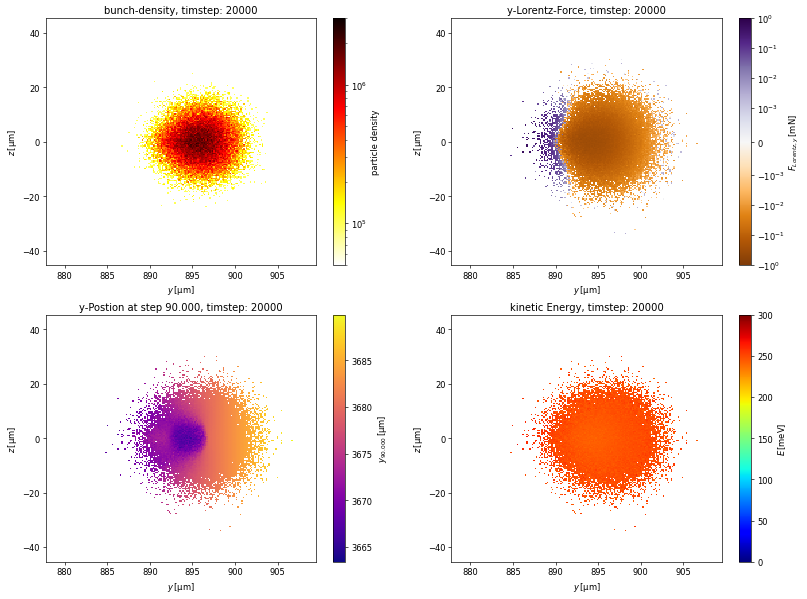

Sum of F_y_L: -7888.863940186411 N


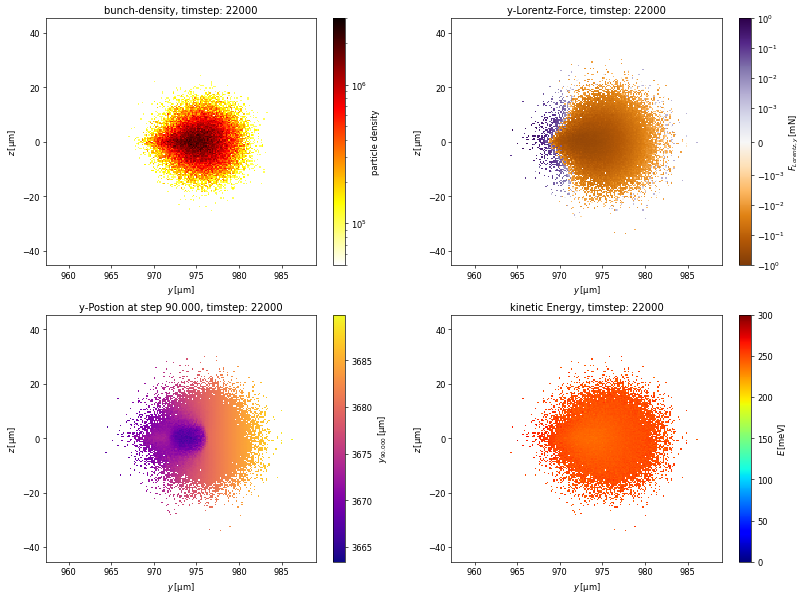

Sum of F_y_L: -10099.998800620056 N


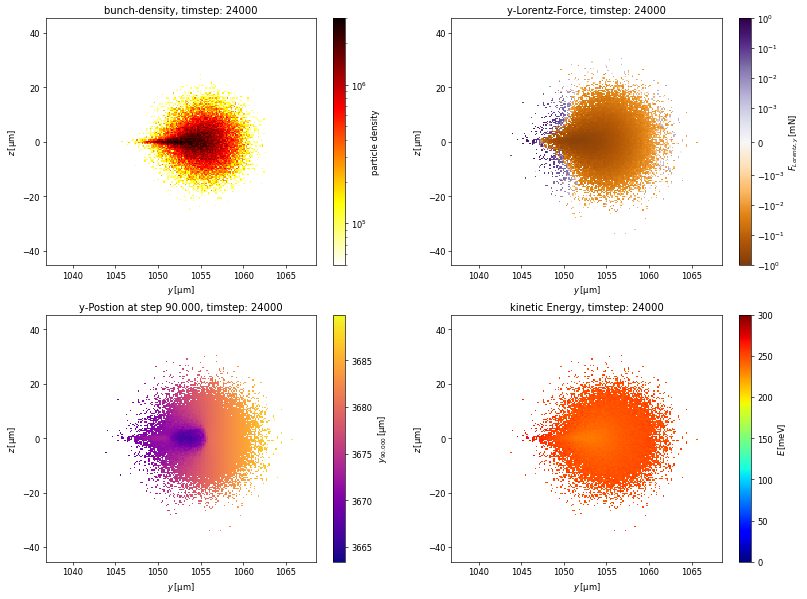

Sum of F_y_L: -13826.524813635728 N


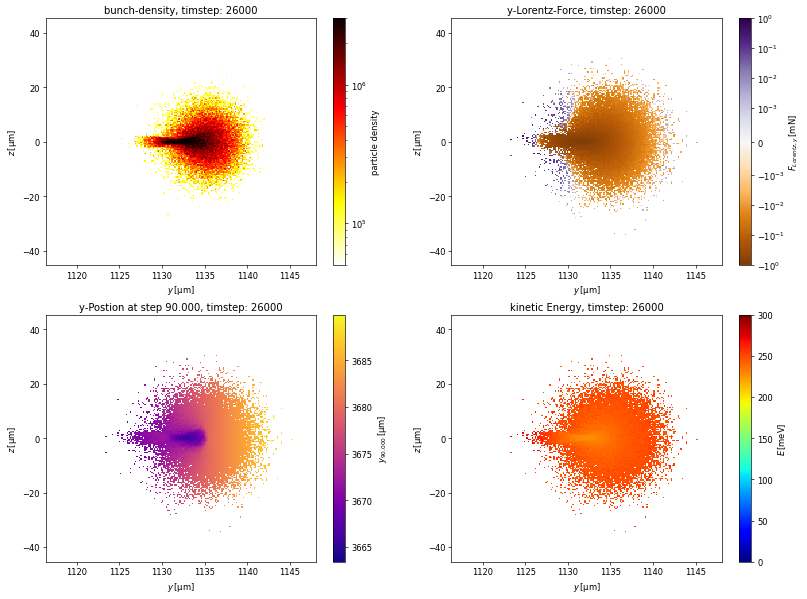

Sum of F_y_L: -17844.771142195303 N


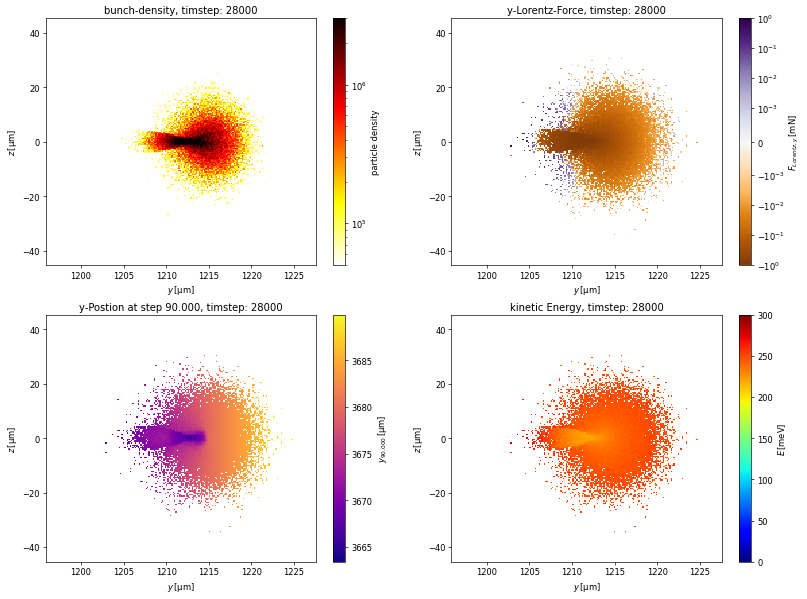

Sum of F_y_L: -20887.053441831147 N


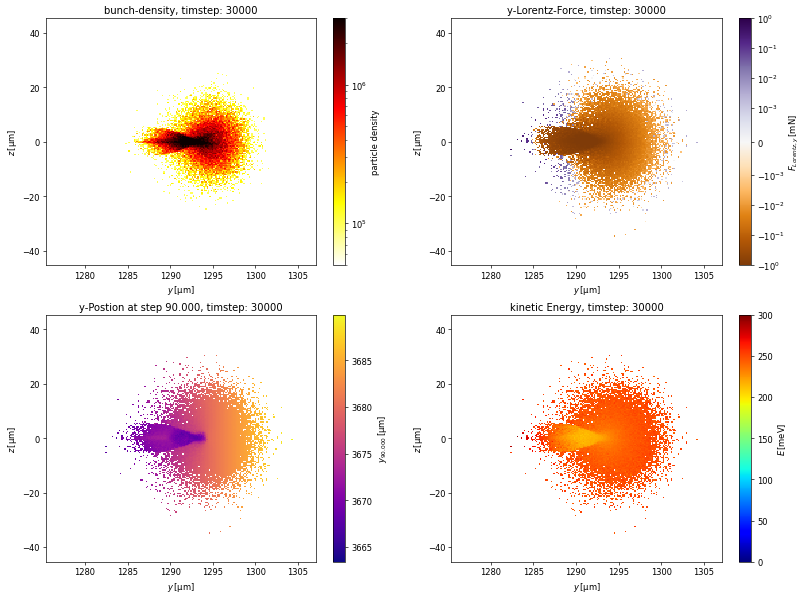

Sum of F_y_L: -22929.232840164317 N


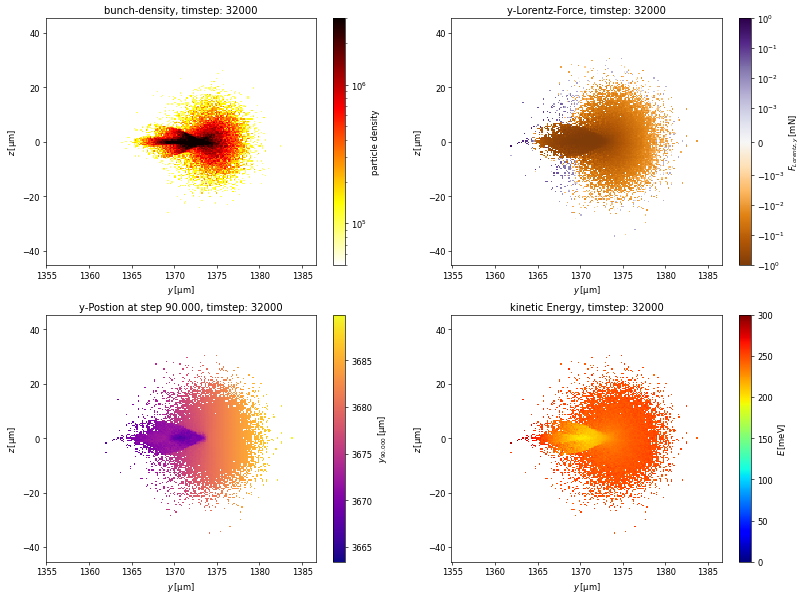

Sum of F_y_L: -24444.870392639714 N


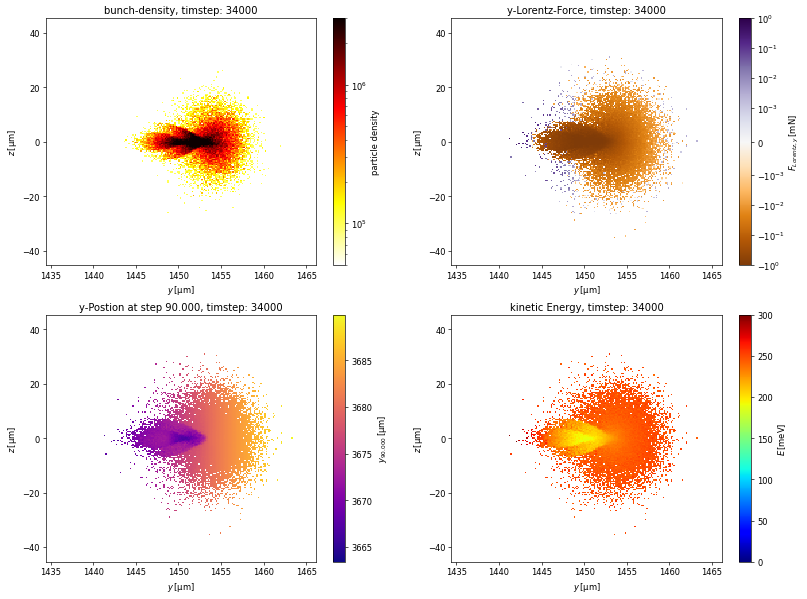

Sum of F_y_L: -25615.44801272245 N


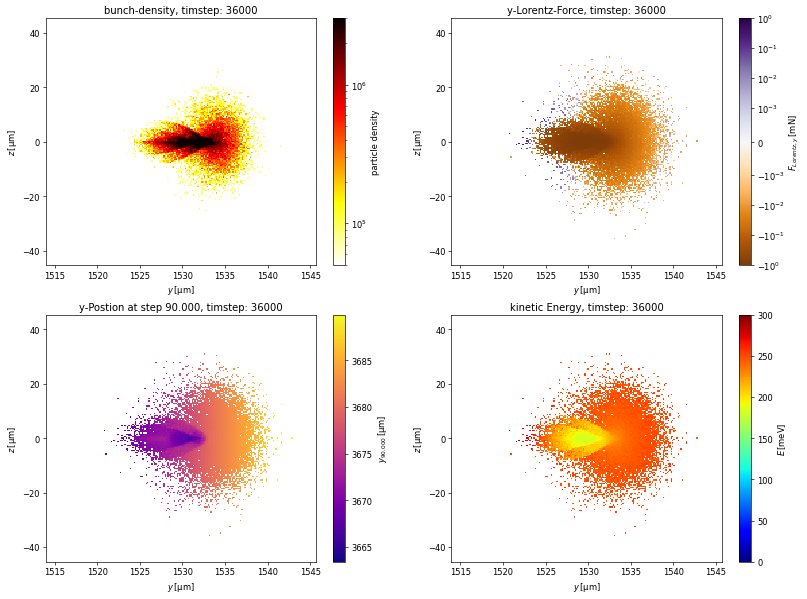

Sum of F_y_L: -26513.397058900868 N


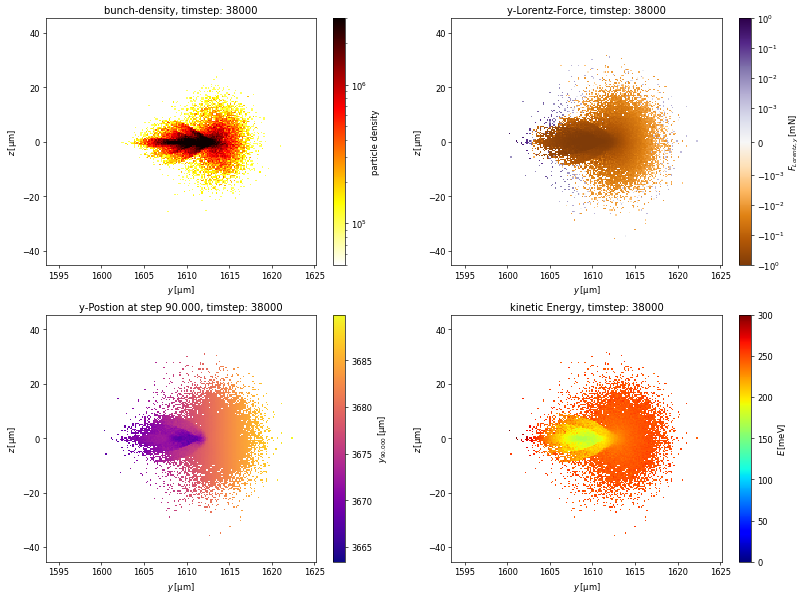

Sum of F_y_L: -27094.675057782308 N


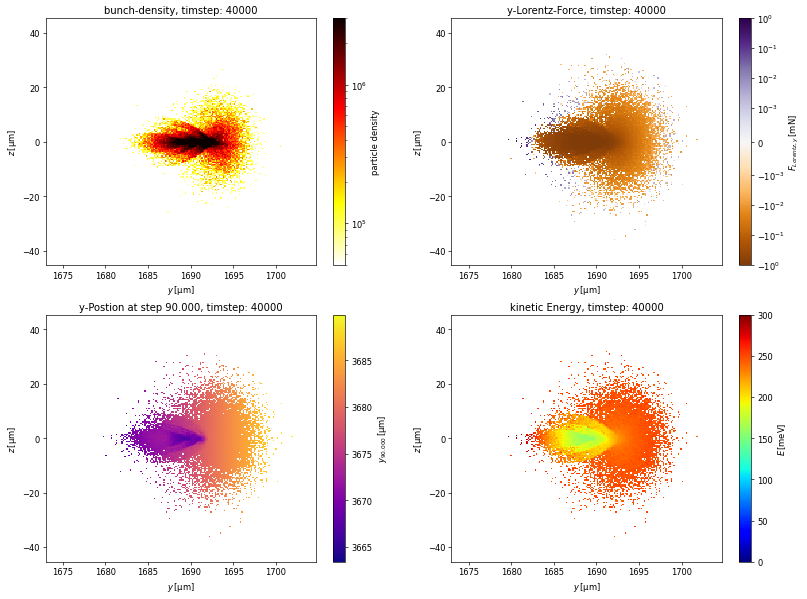

Sum of F_y_L: -27531.725637742074 N


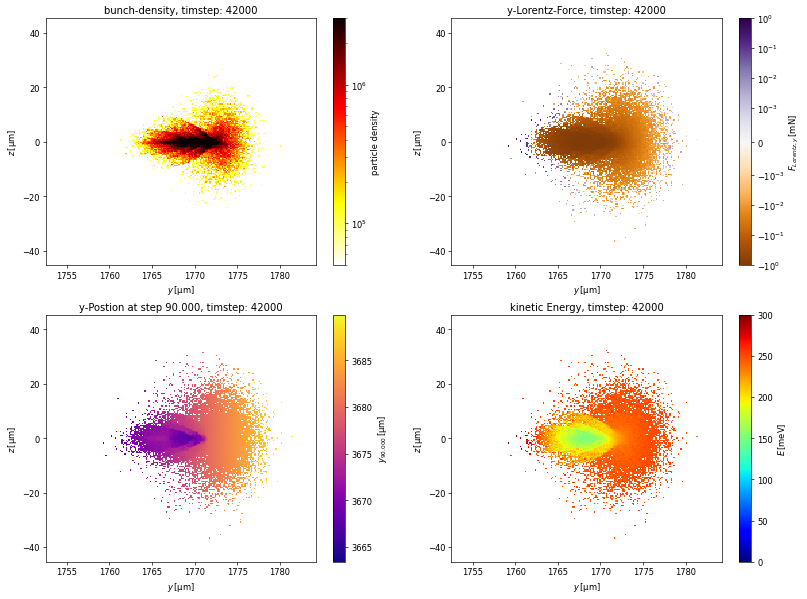

Sum of F_y_L: -27801.25781148527 N


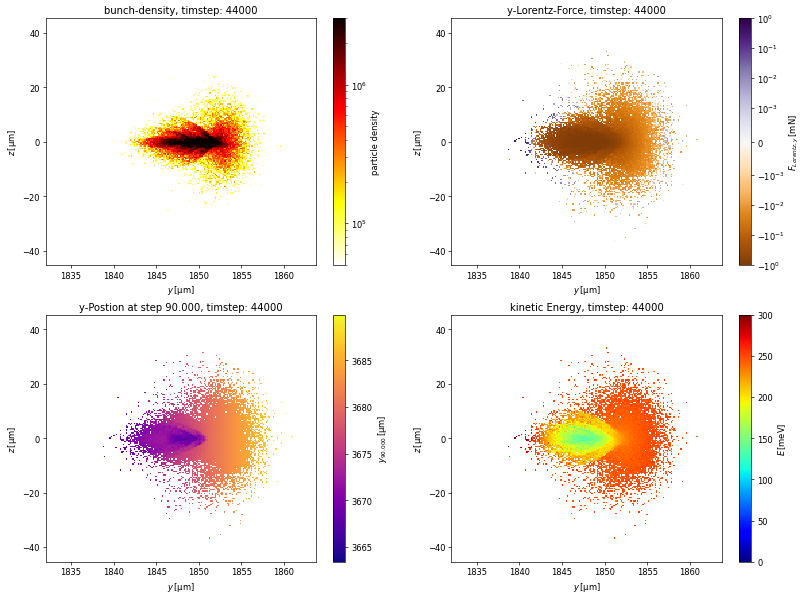

Sum of F_y_L: -27826.967527803405 N


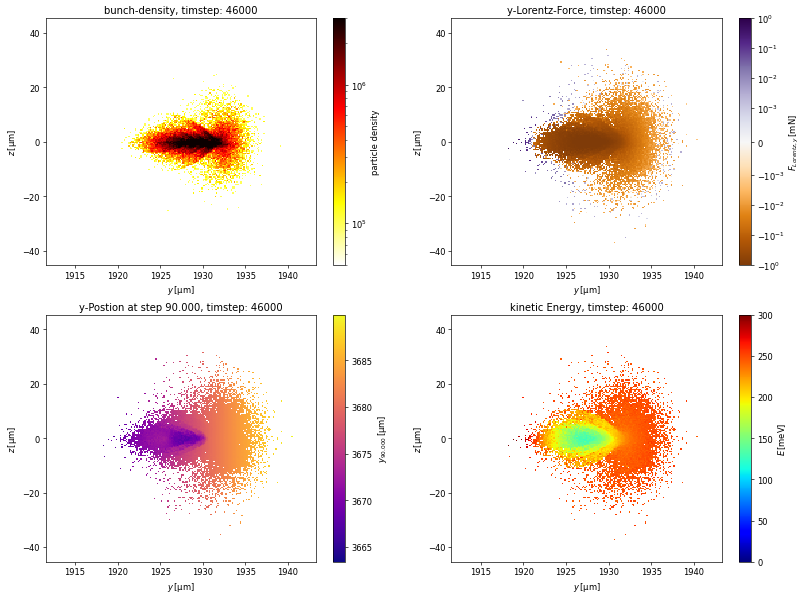

Sum of F_y_L: -27764.786545929575 N


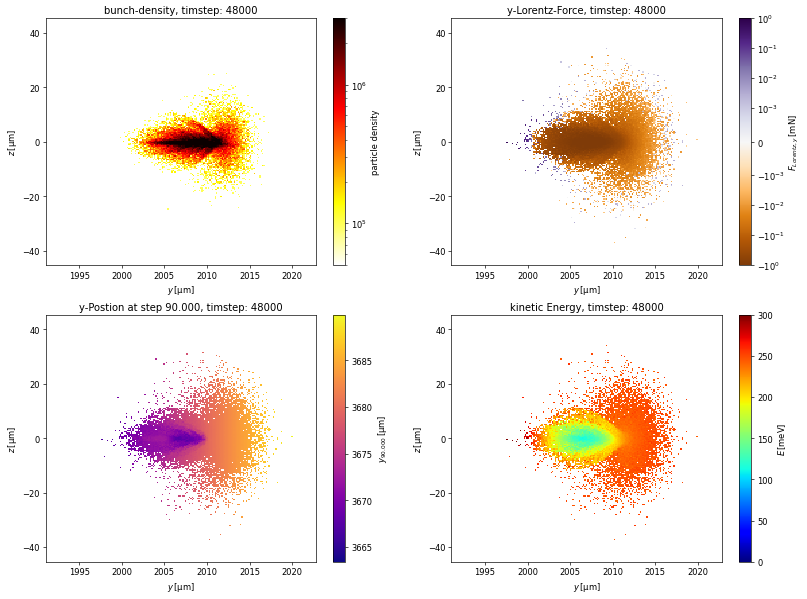

Sum of F_y_L: -27559.69272414743 N


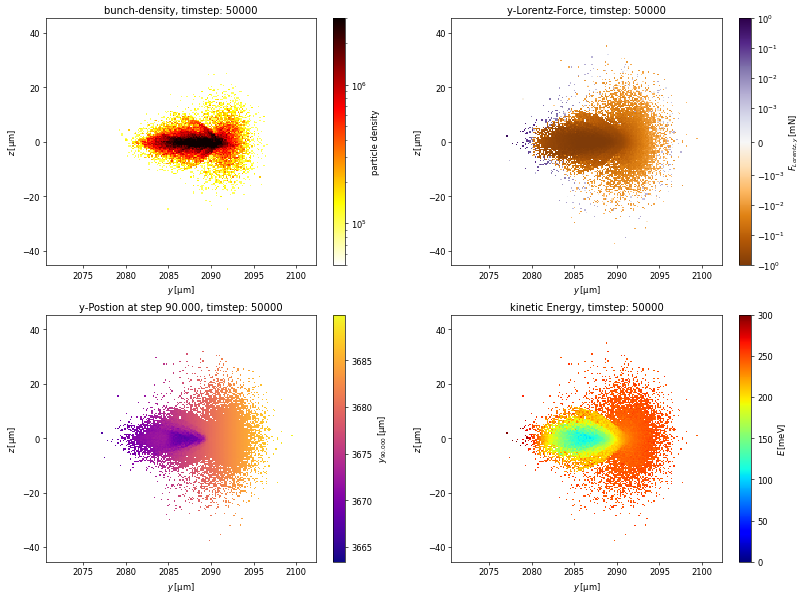

Sum of F_y_L: -27235.943749952392 N


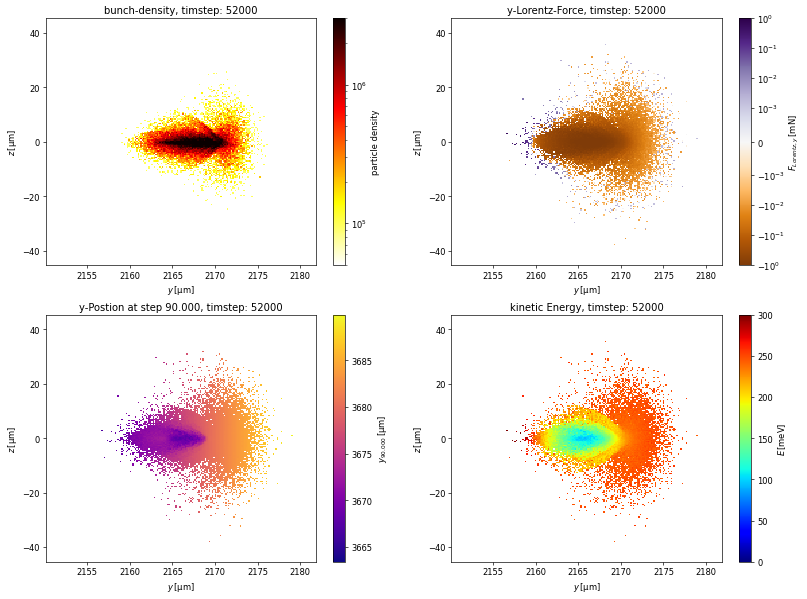

Sum of F_y_L: -26825.229062241375 N


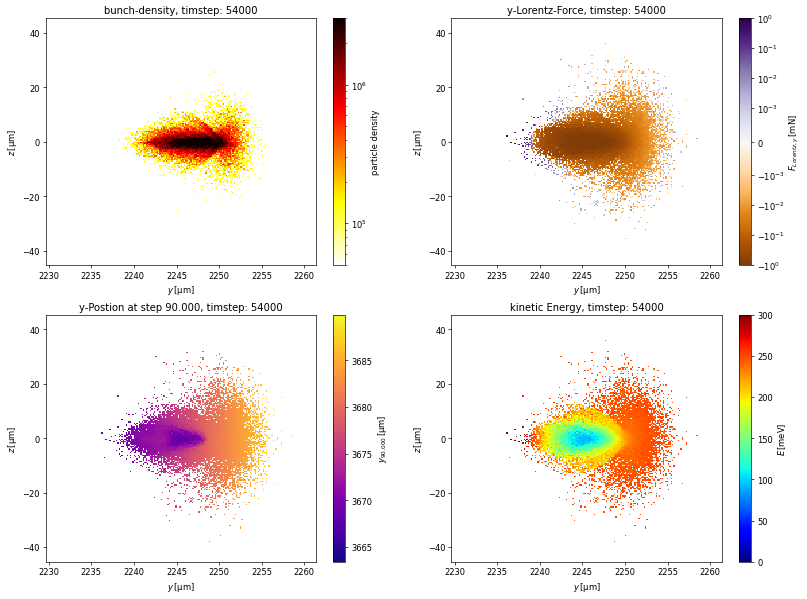

Sum of F_y_L: -26364.401313782986 N


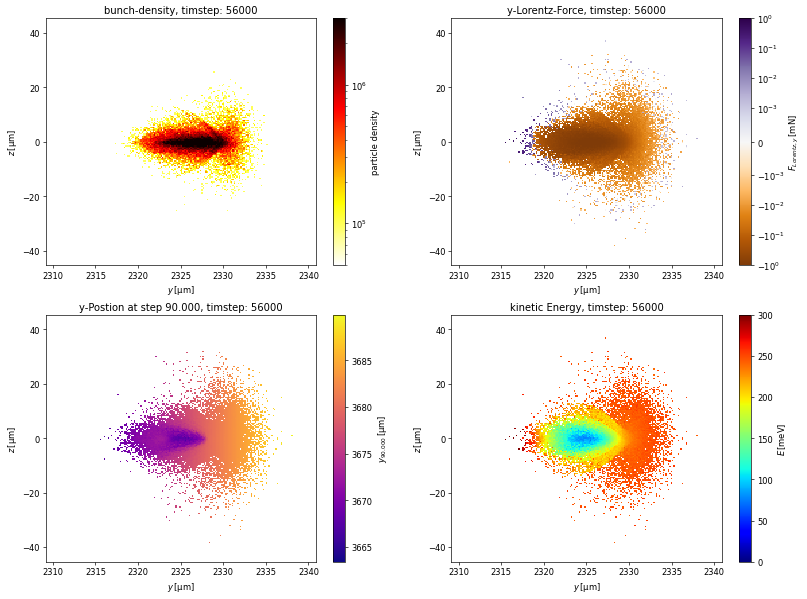

Sum of F_y_L: -25884.587981861536 N


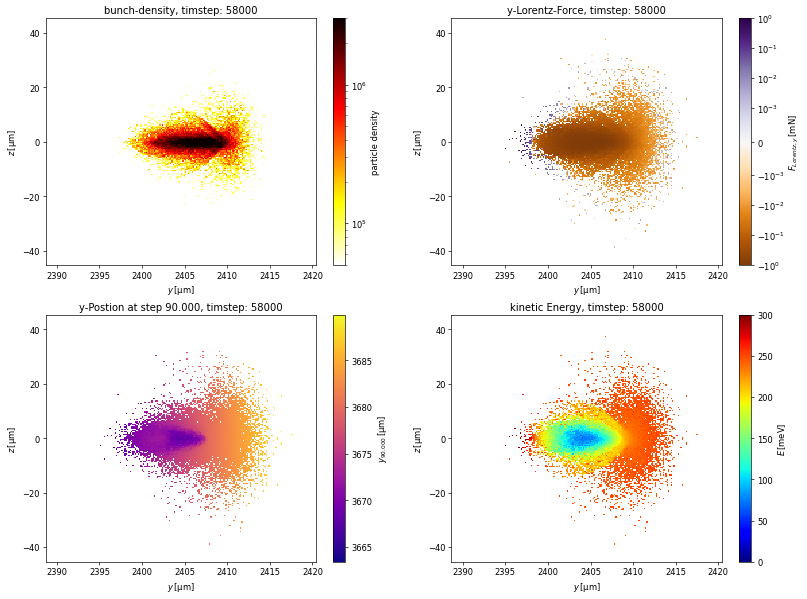

Sum of F_y_L: -25253.22777210762 N


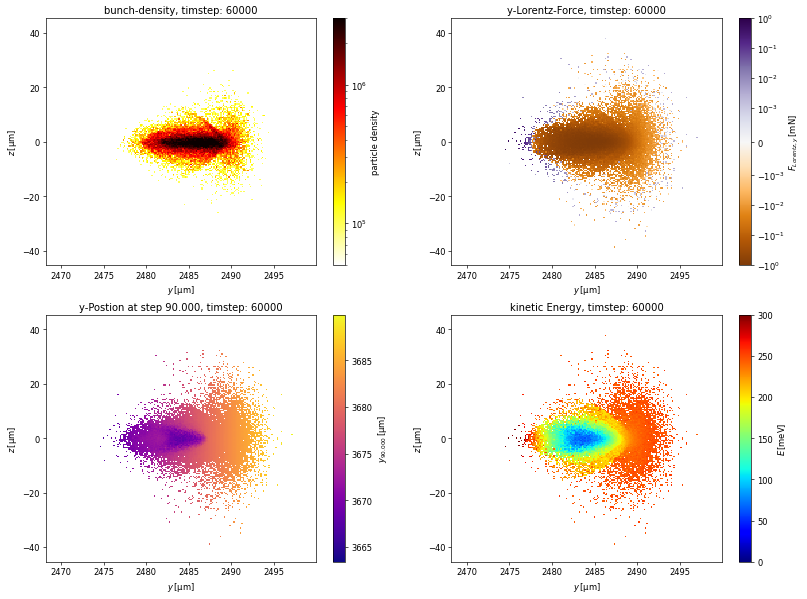

Sum of F_y_L: -24383.063558014022 N


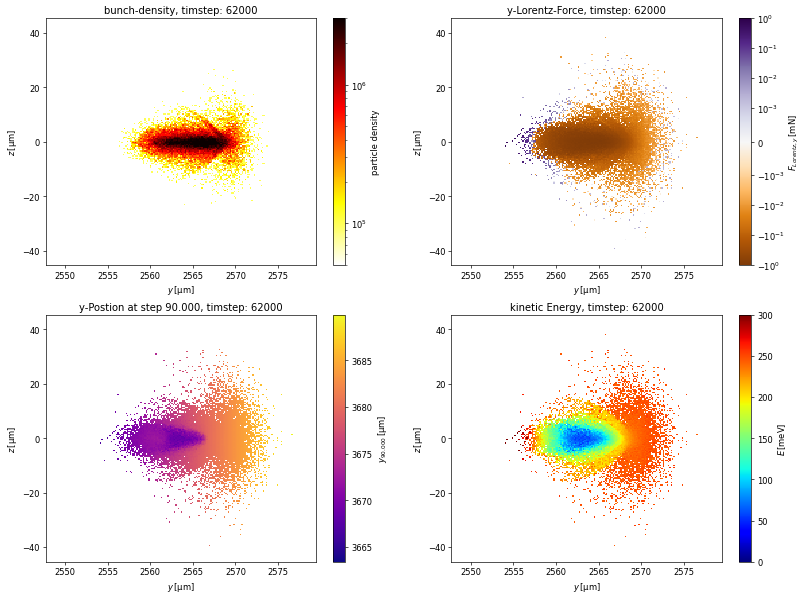

Sum of F_y_L: -23418.414168934043 N


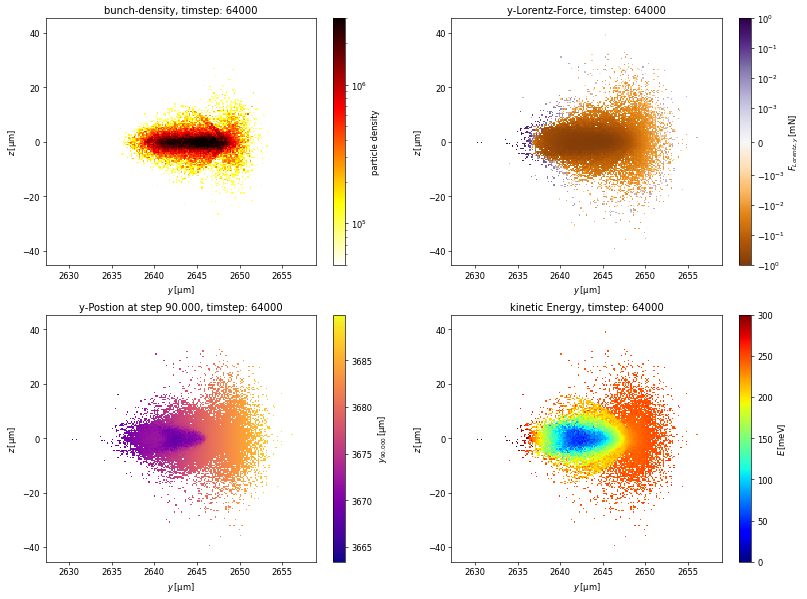

Sum of F_y_L: -21700.475152310184 N


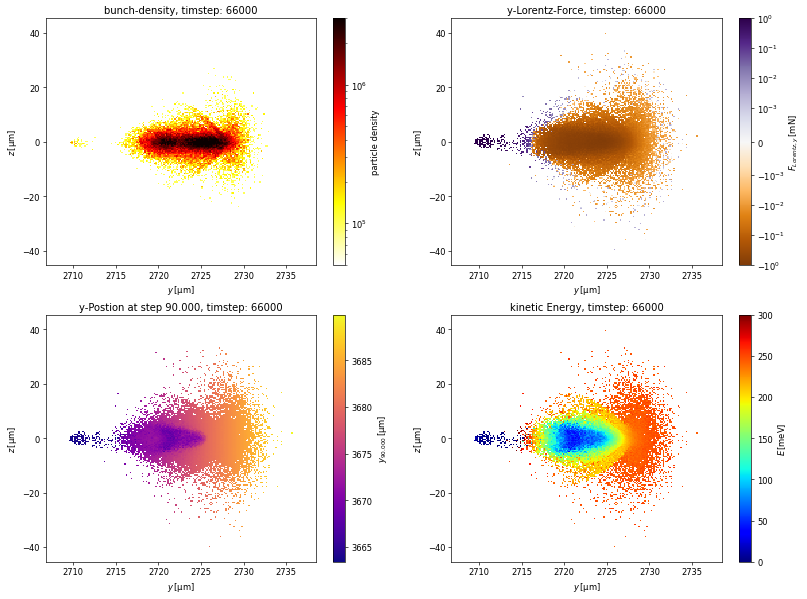

Sum of F_y_L: -18474.15604678415 N


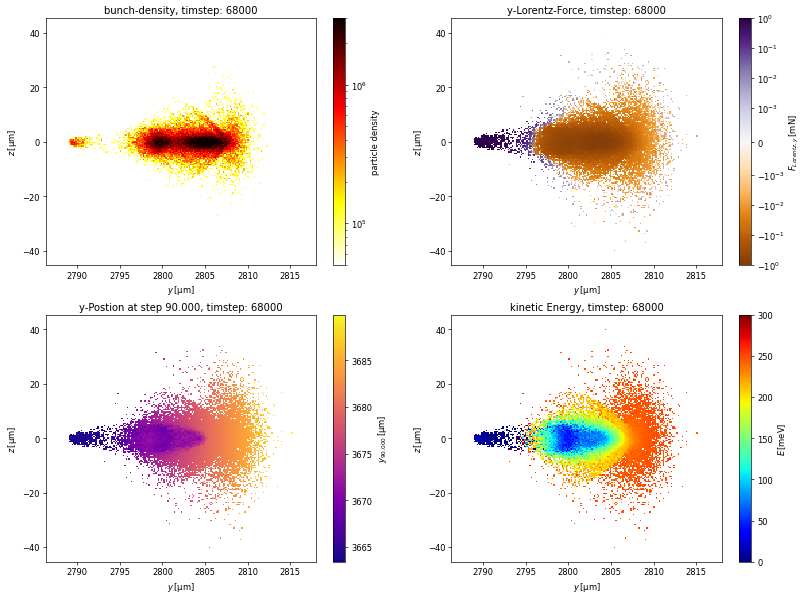

Sum of F_y_L: -14948.549872247682 N


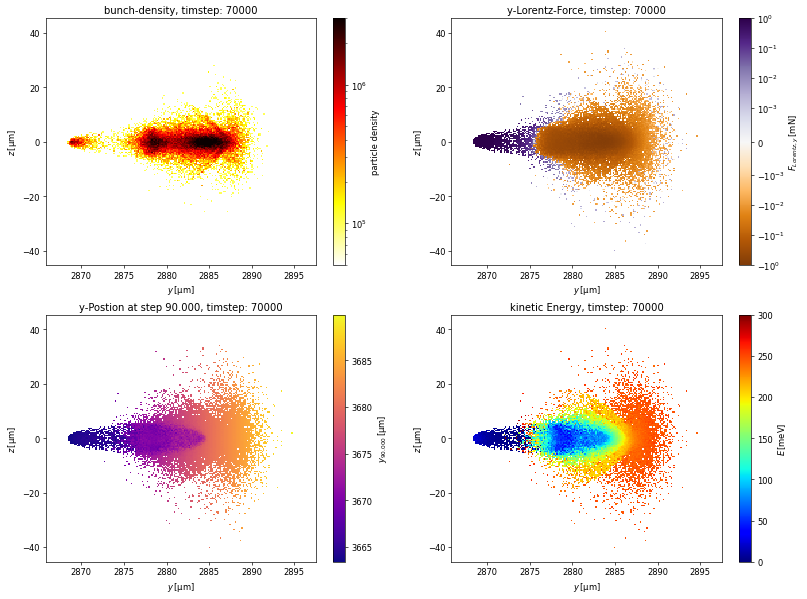

Sum of F_y_L: -12013.055721296982 N


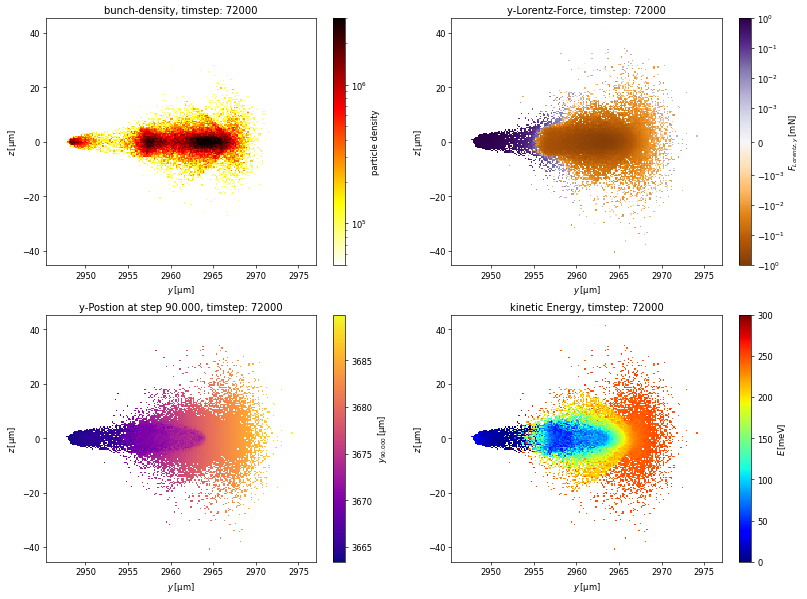

Sum of F_y_L: -9418.414698330316 N


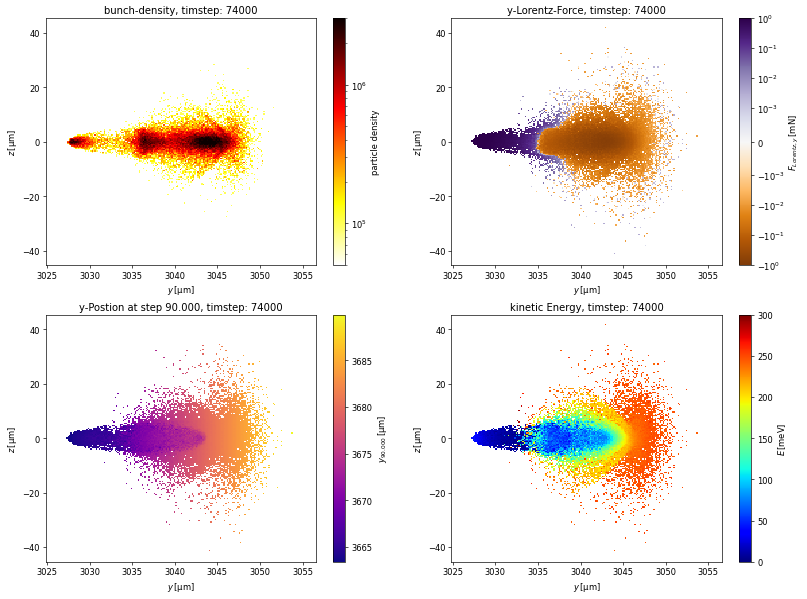

Sum of F_y_L: -7353.449861205163 N


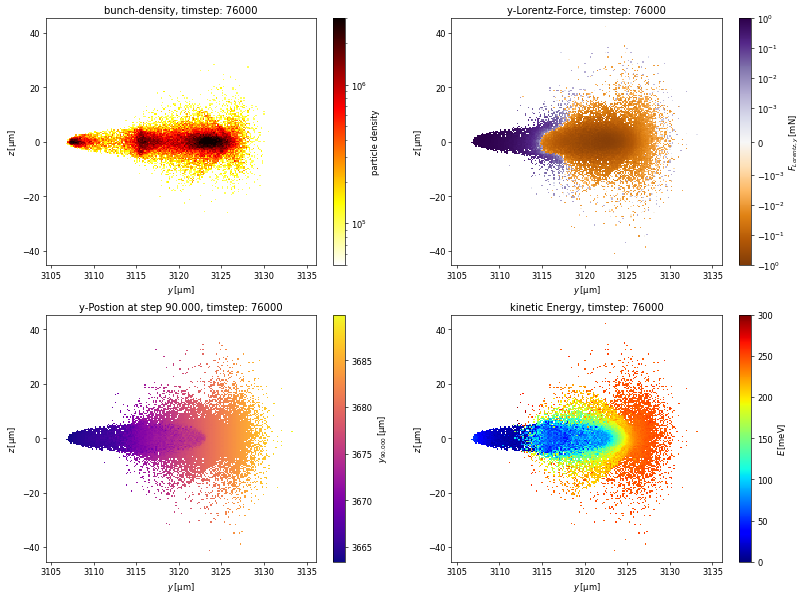

Sum of F_y_L: -5510.601570894788 N


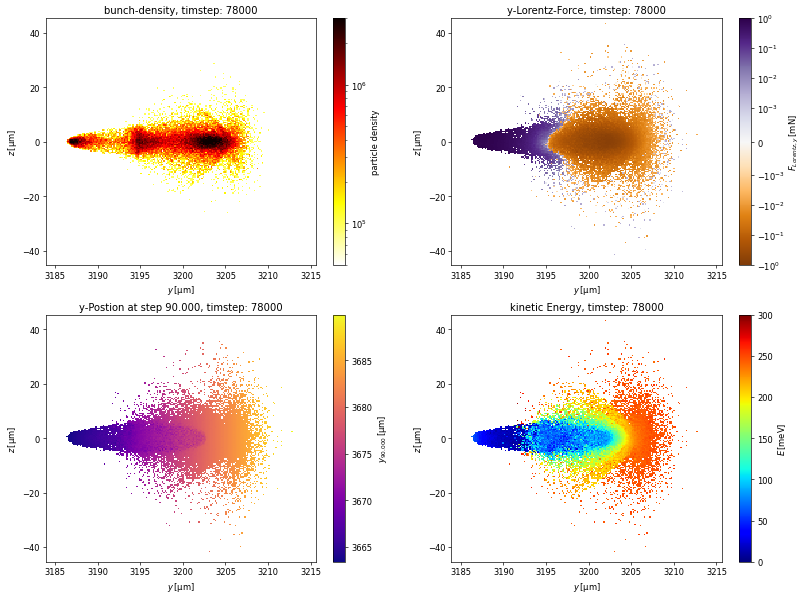

Sum of F_y_L: -4073.271966223412 N


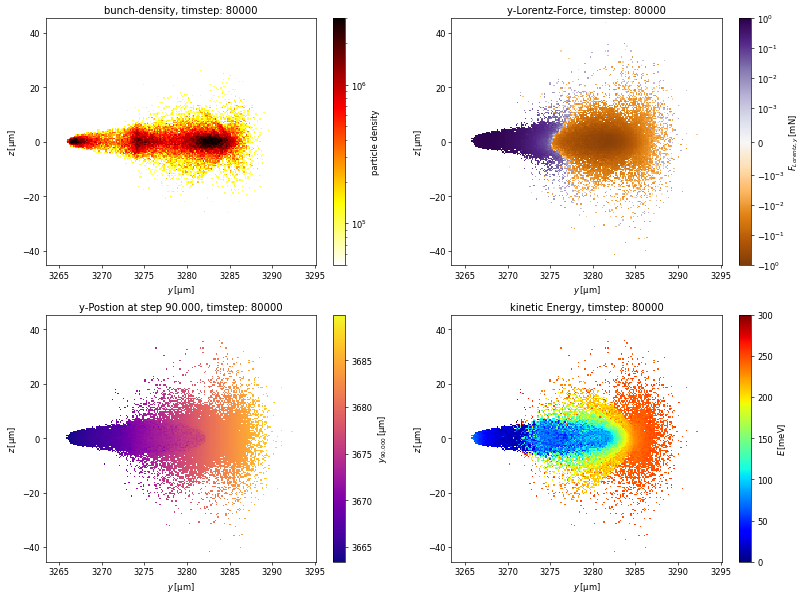

Sum of F_y_L: -3062.9118226632727 N


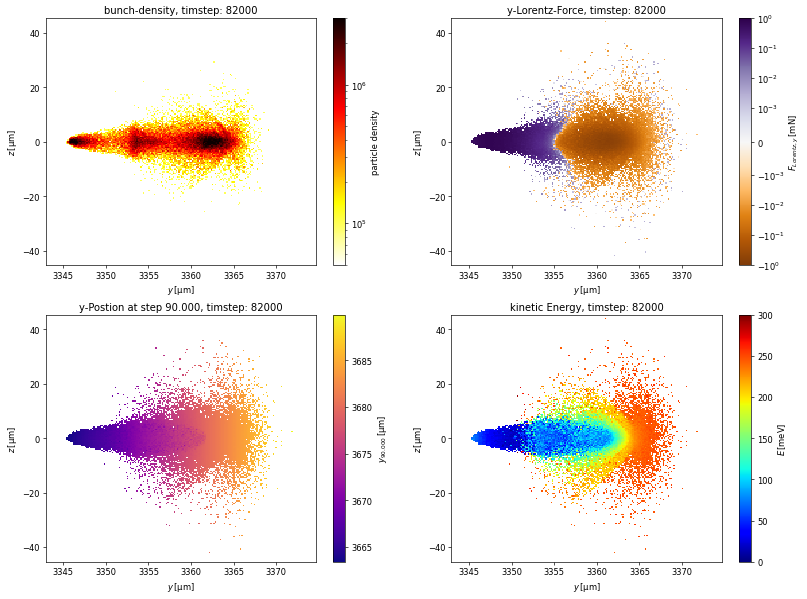

Sum of F_y_L: -2306.8070976201734 N


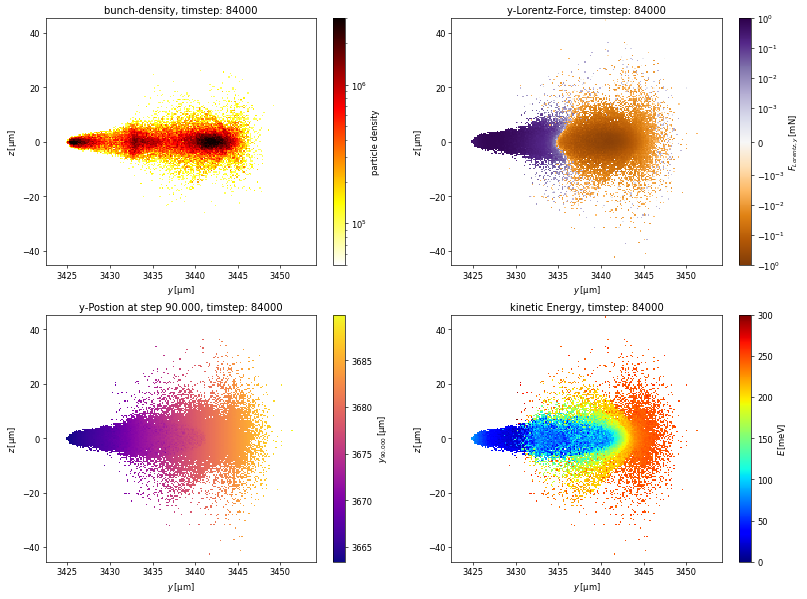

Sum of F_y_L: -1803.6381653665417 N


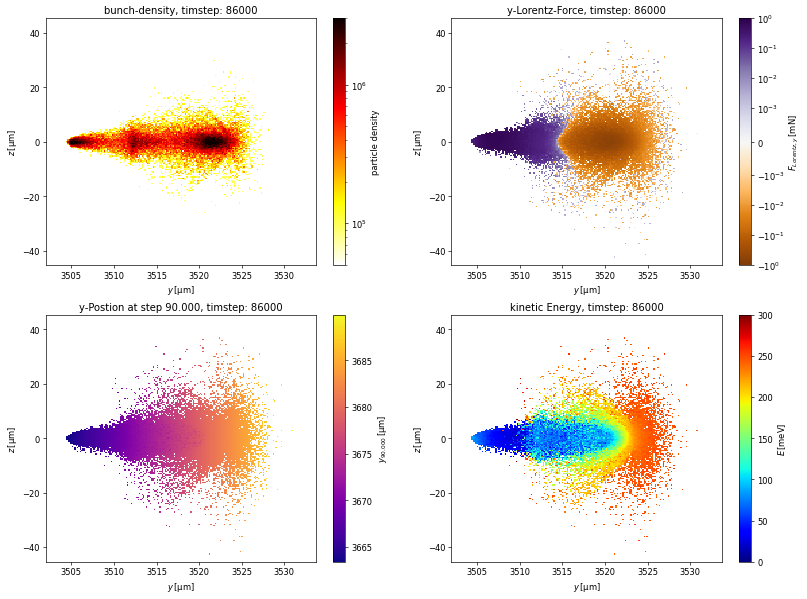

Sum of F_y_L: -1404.5043702477699 N


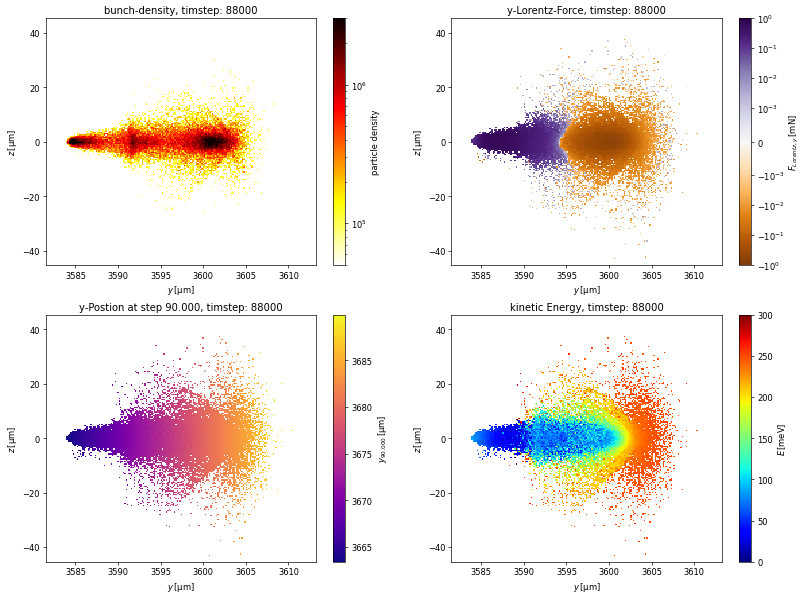

Sum of F_y_L: -1164.1763679167193 N


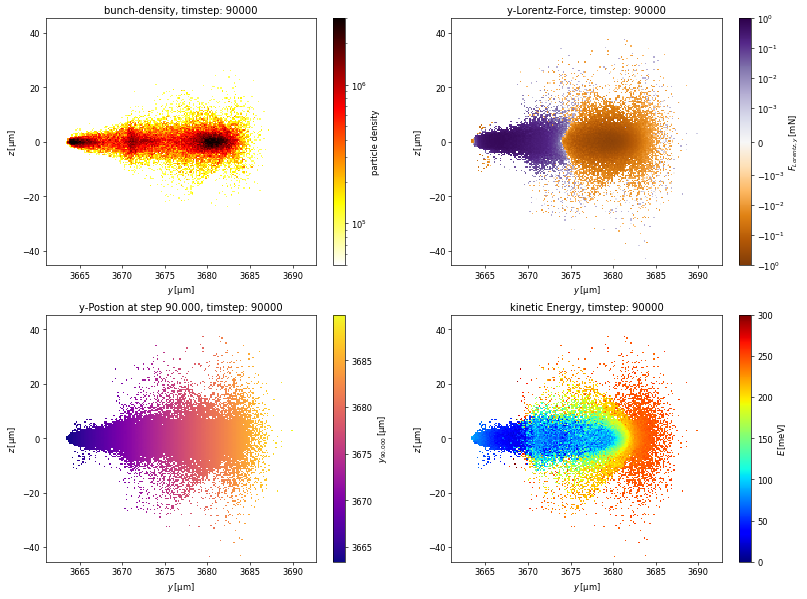

In [10]:
series = io.Series(path, io.Access.read_only)
time = range(20000, 90000+1, 2000)

# get y_pos at last timestep to show how particles changed position
particle = series.iterations[time[-1]].particles["b_all"]
weight, x_pos, y_pos_end, z_pos, particleId_end = particlePMD(particle, mom=False, Id=True)
y_hist = np.zeros((len(time), 201))

for i, t in enumerate(time):
    particle = series.iterations[t].particles["b_all"]
    weight, x_pos, y_pos, z_pos, x_mom, y_mom, z_mom, x_probeE, y_probeE, z_probeE, x_probeB, y_probeB, z_probeB, particleId = particlePMD(particle, probeE=True, probeB=True, Id=True)

    # size of viewing window
    y_min = Delta_t * constants.c * t * 1e6 + windowwidth * 0.52
    y_max = Delta_t * constants.c * t * 1e6 + windowwidth * 0.72
    z_min = -windowheight / 2
    z_max =  windowheight / 2
    
    # converting momenta to velocity
    x_vel = np.sqrt((x_mom / (constants.m_e*weight))**2 / (1 + (x_mom**2 + y_mom**2 +z_mom**2) / (constants.m_e*weight)**2 / constants.c**2))
    z_vel = np.sqrt((z_mom / (constants.m_e*weight))**2 / (1 + (x_mom**2 + y_mom**2 +z_mom**2) / (constants.m_e*weight)**2 / constants.c**2))

    F_y_B = z_vel*x_probeB - x_vel*z_probeB
    
    F_y_L = -constants.e*weight * (y_probeE + F_y_B) *1e3
    print("Sum of F_y_L:", np.sum(F_y_L), "N")
    
    statistic, bin_y, bin_z, rest = stats.binned_statistic_2d(y_pos, z_pos, (F_y_L), statistic='mean', bins=201, range=[[y_min, y_max], [z_min, z_max]])
    y, z = binned_to_grid(bin_y, bin_z)
    
    E = mom_to_E(x_mom, y_mom, z_mom)
    
    plt.figure(dpi=60, figsize=(16, 12))
    plt.subplot(221)
    plt.hist2d(y_pos, z_pos, bins=200,  weights=weight, cmap='hot_r', norm=LogNorm(vmin=5e4, vmax=3e6), range=[[y_min, y_max], [z_min, z_max]])
    plt.colorbar(label='particle density')
#    plt.imshow(statistic[0].T, color=col, cmap='Greens')
#    plt.colorbar(label='$F_{Lorentz} \, \mathrm{[mN]}$')
    plt.xlabel("$y \, \mathrm{[\mu m]}$")
    plt.ylabel("$z \, \mathrm{[\mu m]}$")
    plt.title("bunch-density, timstep: {:1d}".format(t))
    
    plt.subplot(222)
    plt.imshow(statistic.T, cmap='PuOr', extent=(bin_y[0], bin_y[-1], bin_z[0], bin_z[-1]), aspect='auto', origin="lower", interpolation='none', norm=SymLogNorm(linthresh=1e-3, vmin=-1, vmax=1))
    plt.colorbar(label='$F_{Lorentz, y} \, \mathrm{[mN]}$')
    plt.xlabel("$y \, \mathrm{[\mu m]}$")
    plt.ylabel("$z \, \mathrm{[\mu m]}$")
    plt.title("y-Lorentz-Force, timstep: {:1d}".format(t))

    statistic, bin_y, bin_z, rest = stats.binned_statistic_2d(y_pos, z_pos, (E), statistic='mean', bins=201, range=[[y_min, y_max], [z_min, z_max]])
    plt.subplot(224)
    plt.imshow(statistic.T, cmap='jet', vmin=0, vmax=300, extent=(bin_y[0], bin_y[-1], bin_z[0], bin_z[-1]), aspect='auto', origin="lower", interpolation='none')
    plt.colorbar(label='$E \, \mathrm{[meV]}$')
    plt.xlabel("$y \, \mathrm{[\mu m]}$")
    plt.ylabel("$z \, \mathrm{[\mu m]}$")
    plt.title("kinetic Energy, timstep: {:1d}".format(t))
    
    mask = np.isin(particleId, particleId_end)
    ind = np.argsort(particleId[mask])
    ind_end = np.argsort(particleId_end)
    statistic, bin_y, bin_z, rest = stats.binned_statistic_2d((y_pos[mask])[ind], (z_pos[mask])[ind], (y_pos_end[ind_end]), statistic='mean', bins=201, range=[[y_min, y_max], [z_min, z_max]])

    y_hist[i] = statistic[:, 100]
    
    plt.subplot(223)
    plt.imshow(statistic.T, cmap='plasma', extent=(bin_y[0], bin_y[-1], bin_z[0], bin_z[-1]), aspect='auto', vmin=np.min(y_pos_end), vmax=np.max(y_pos_end), origin="lower", interpolation='none')
    plt.colorbar(label='$y_{90.000} \, \mathrm{[\mu m]}$')
    plt.xlabel("$y \, \mathrm{[\mu m]}$")
    plt.ylabel("$z \, \mathrm{[\mu m]}$")
    plt.title("y-Postion at step 90.000, timstep: {:1d}".format(t))    
    plt.show()
#    plt.savefig(fname="temp", facecolor="white", dpi=300)
del series

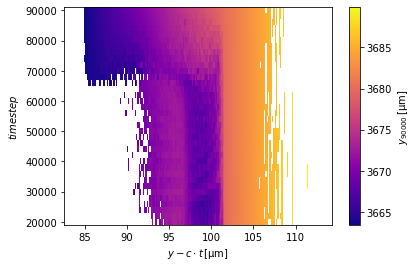

In [42]:
plt.imshow(y_hist, cmap="plasma", origin="lower", aspect='auto', vmin=np.min(y_pos_end), vmax=np.max(y_pos_end), extent=(windowwidth * 0.52, windowwidth * 0.72, time[0]-1e3, time[-1]+1e3), interpolation='none')
plt.colorbar(label="$y_{90 000} \, \mathrm{[\mu m]}$")
plt.xlabel("$y-c\cdot t \, \mathrm{[\mu m]}$")
plt.ylabel("$timestep$")
plt.show()
# Bins müssten immmer die Breite haben, damit das klappt, also erst mit Offset

## Test Multidimensional color

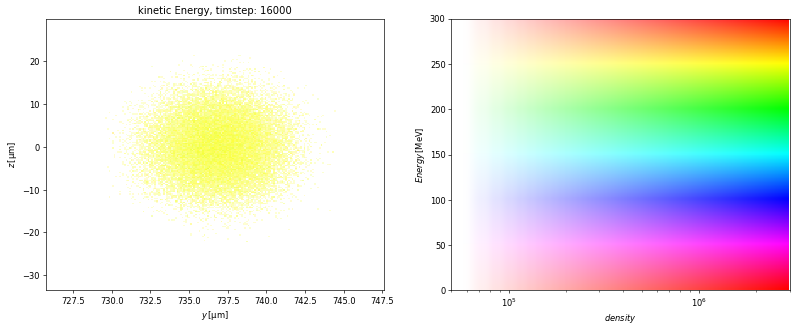

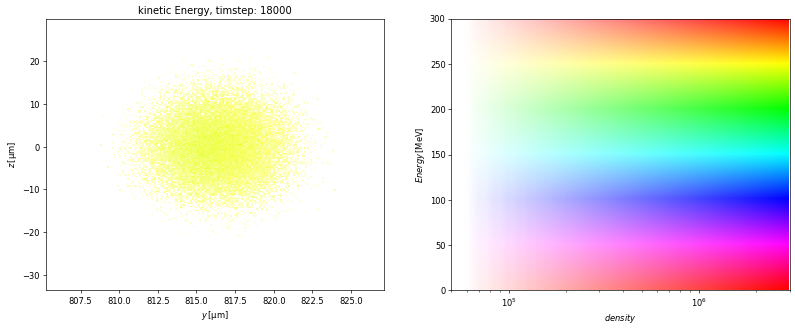

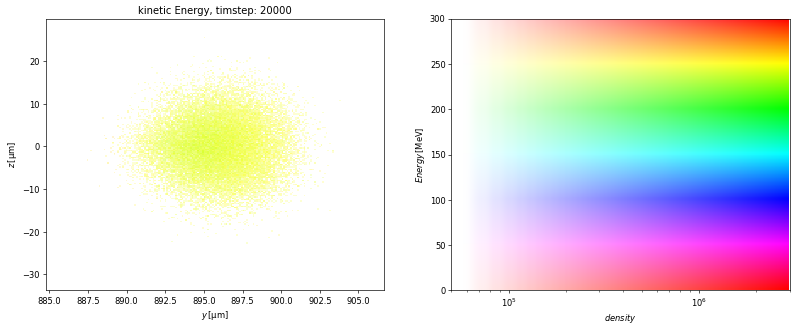

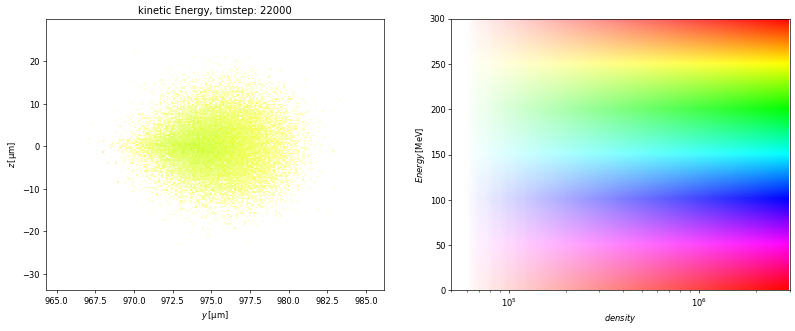

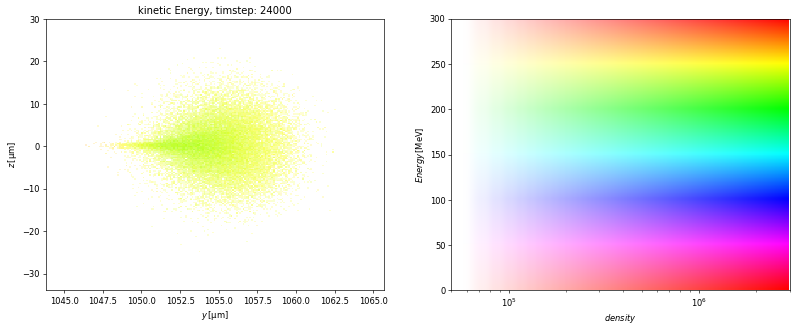

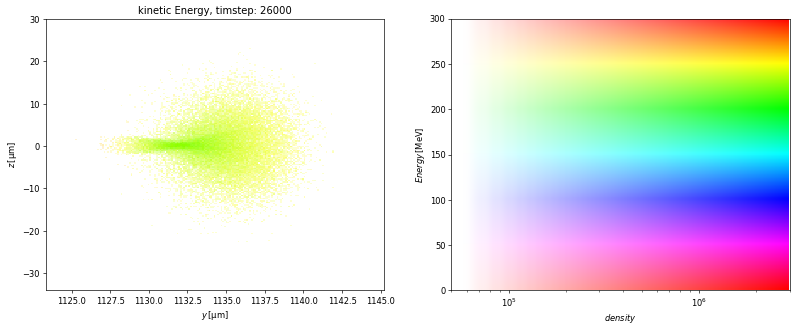

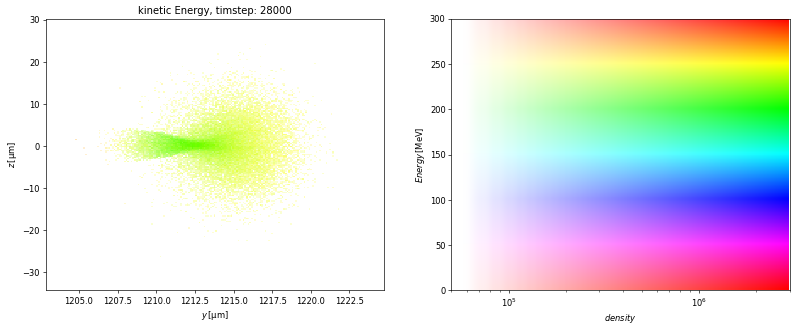

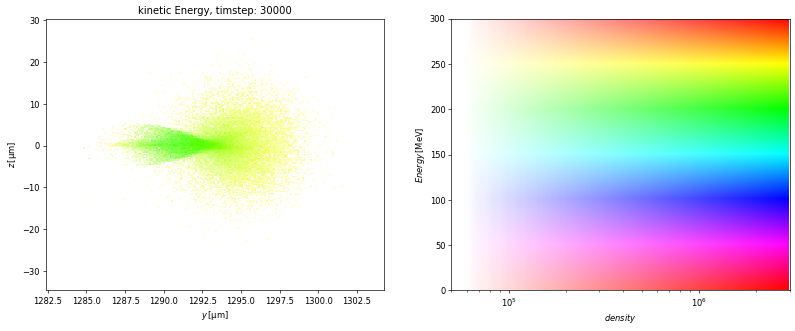

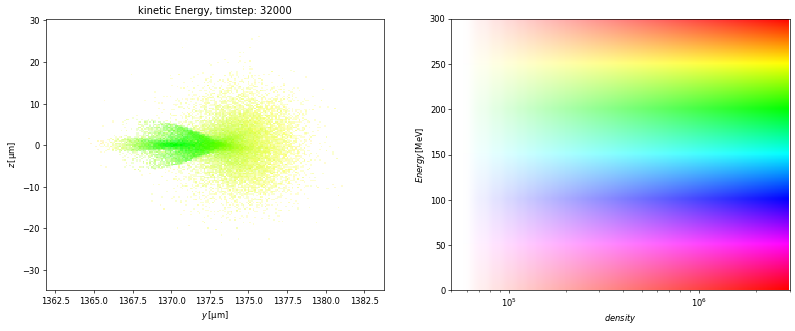

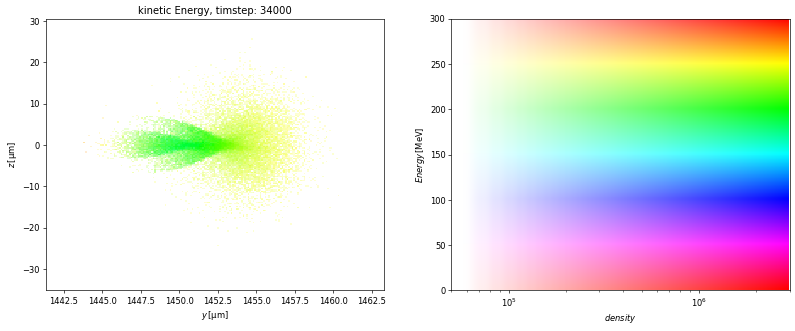

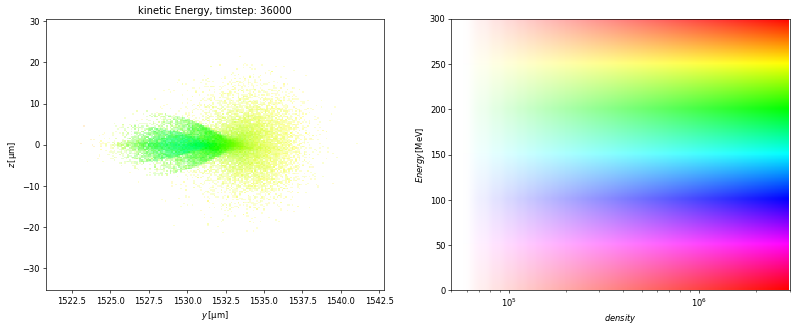

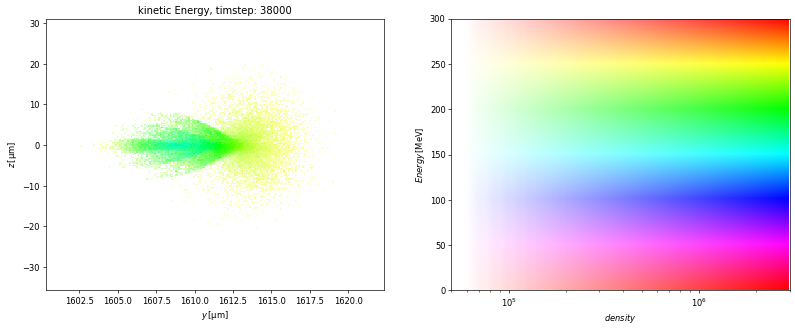

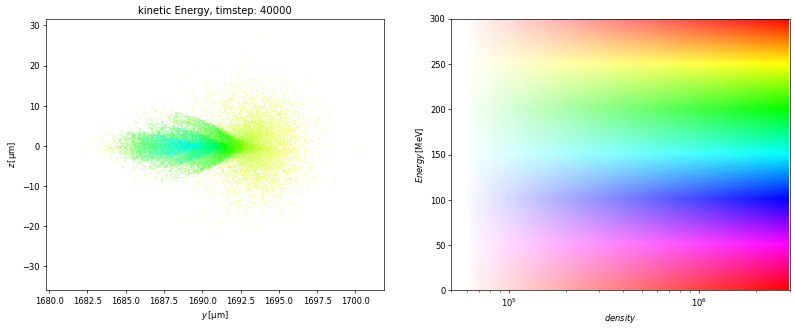

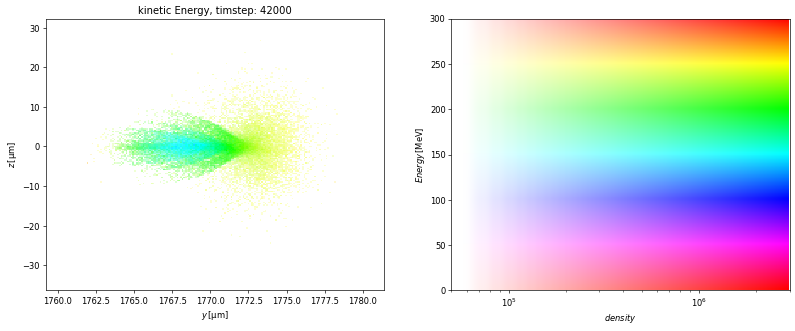

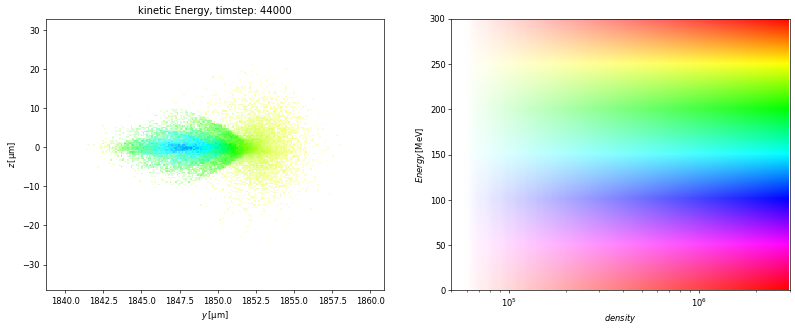

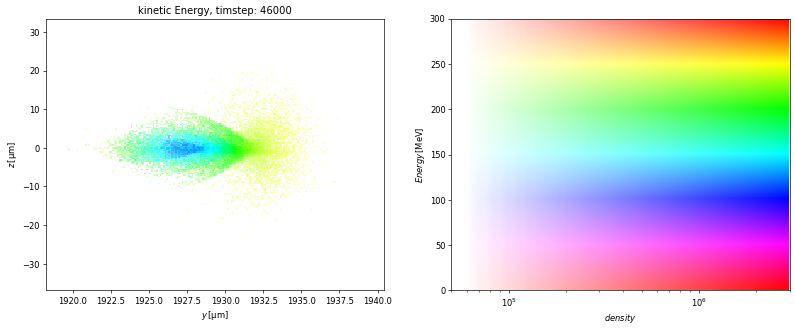

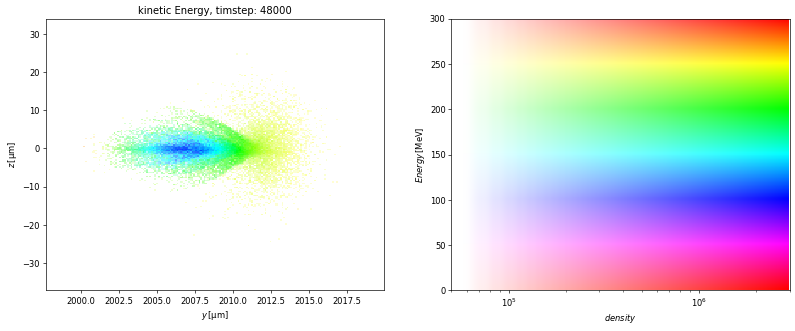

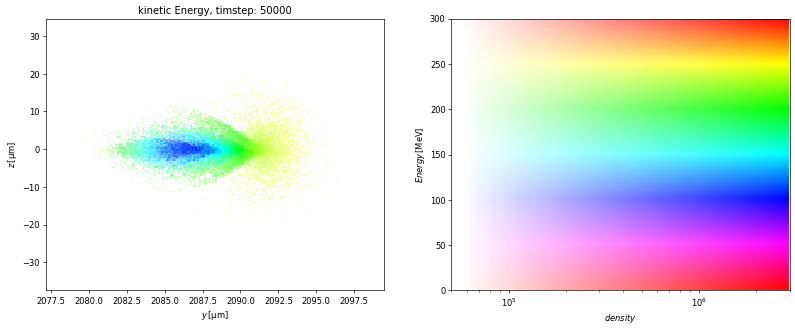

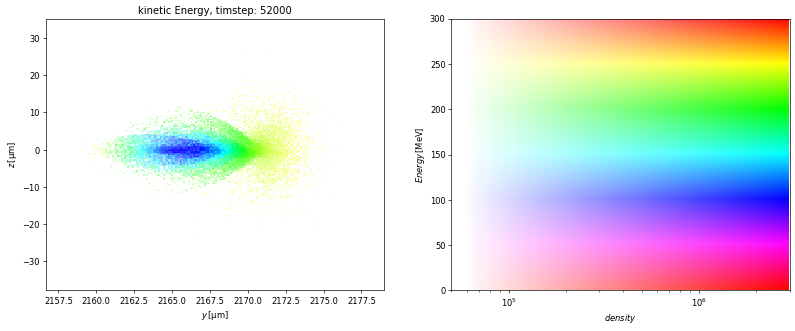

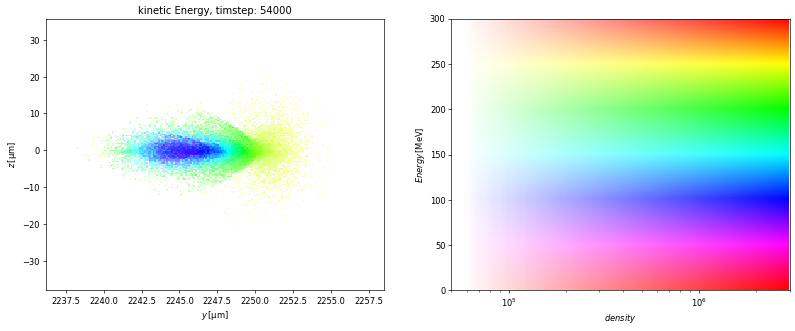

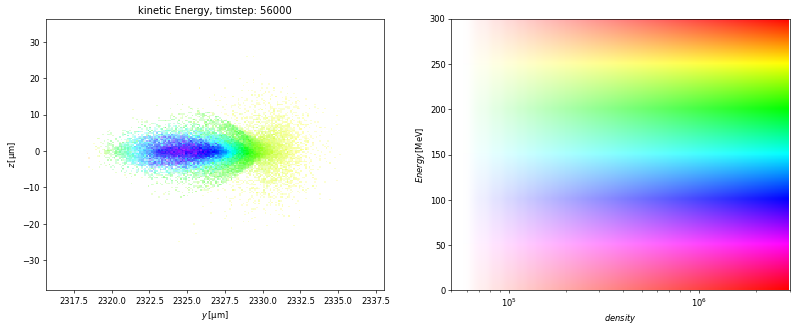

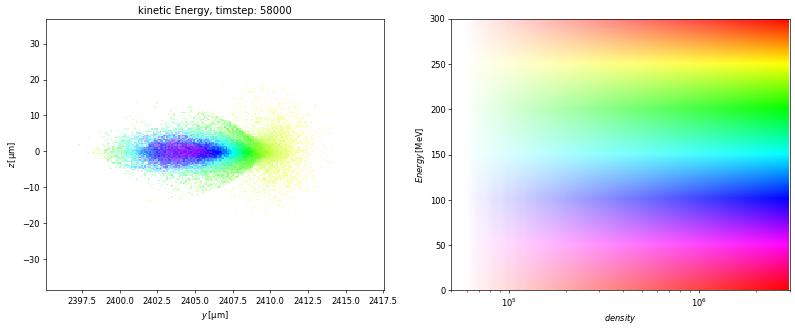

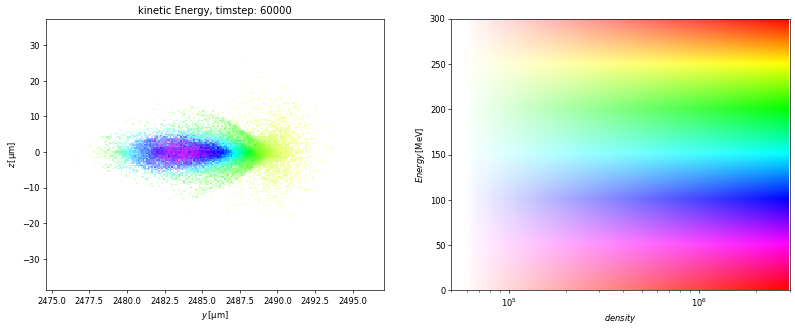

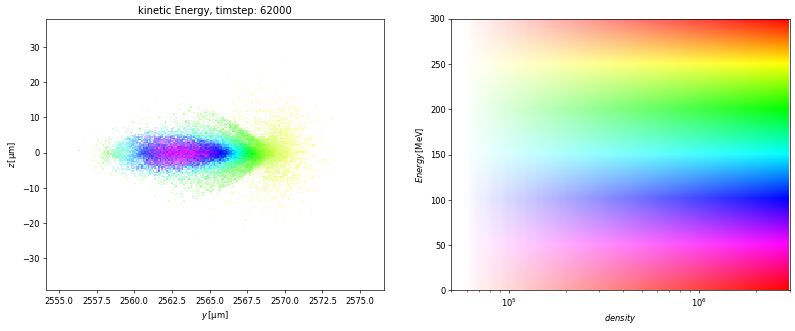

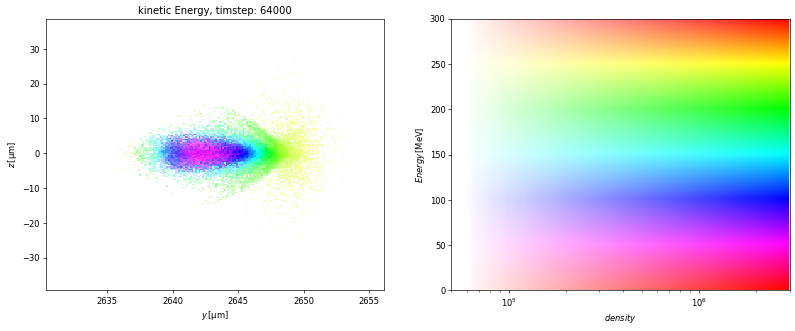

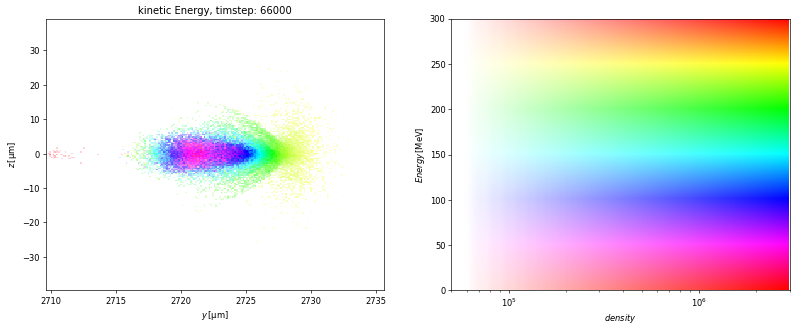

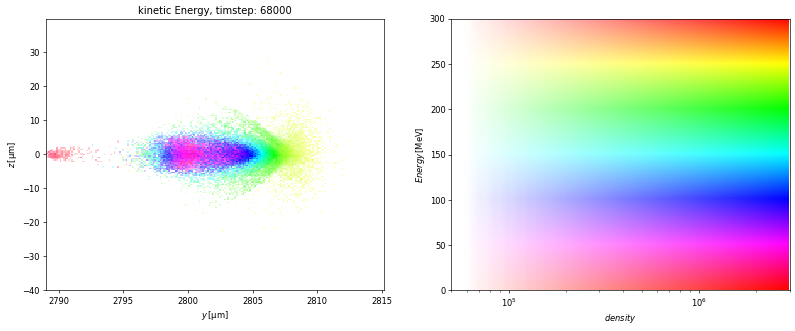

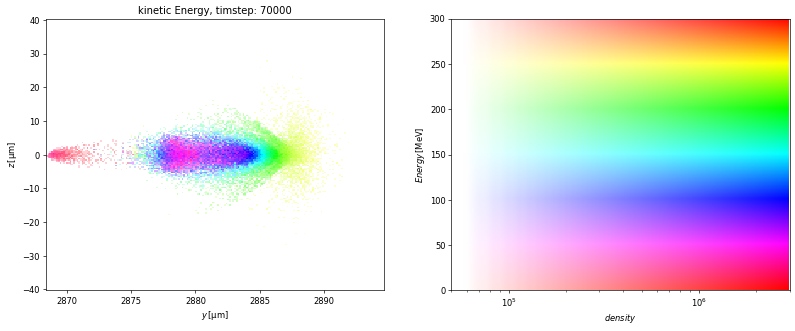

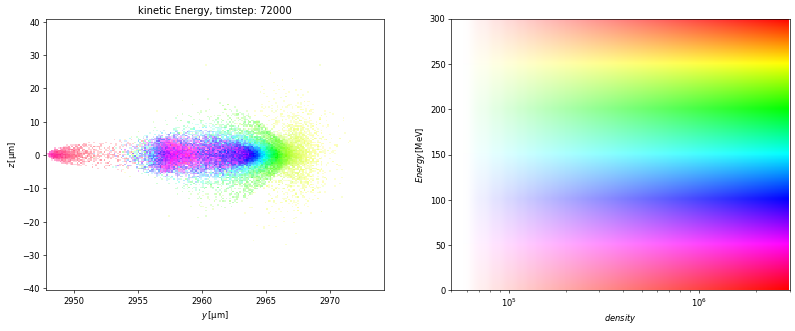

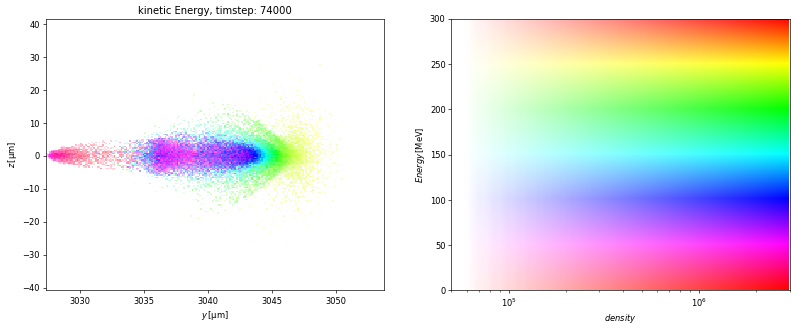

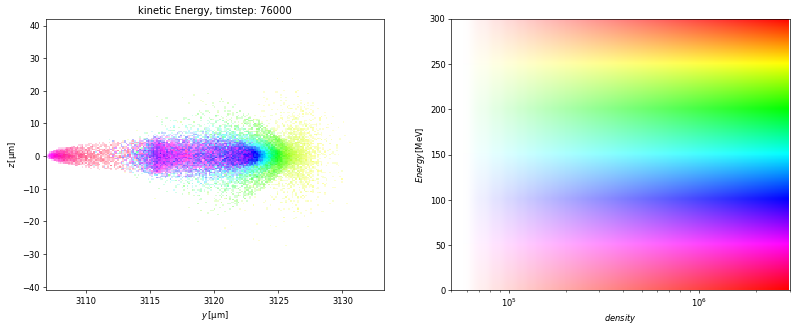

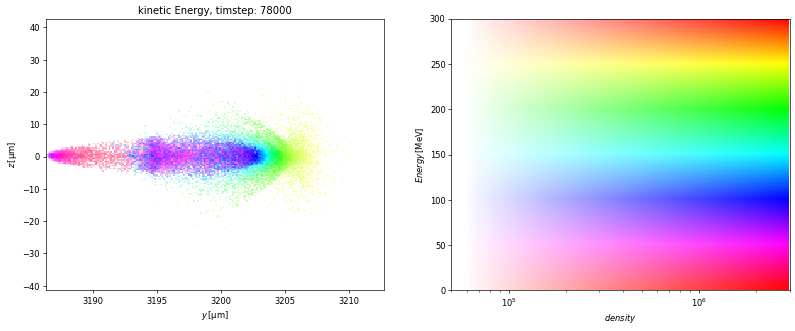

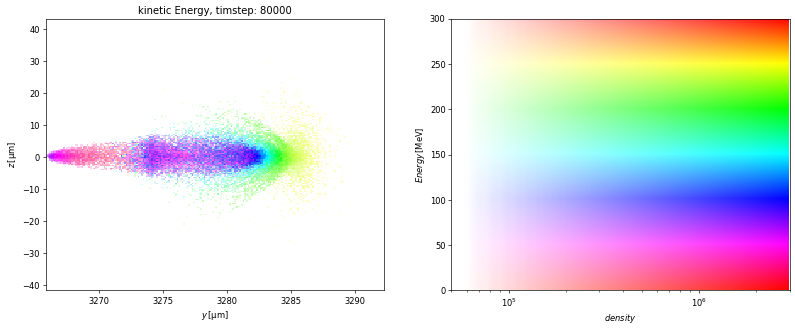

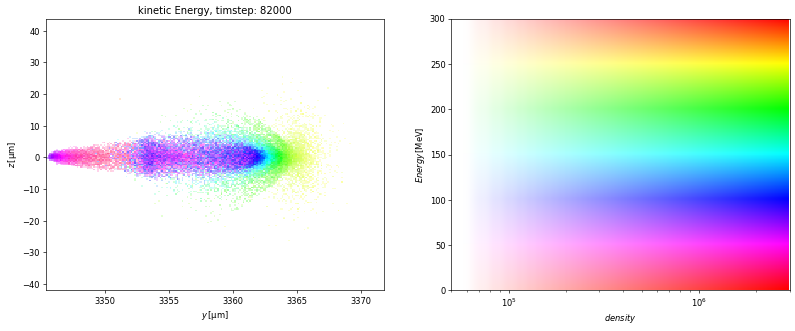

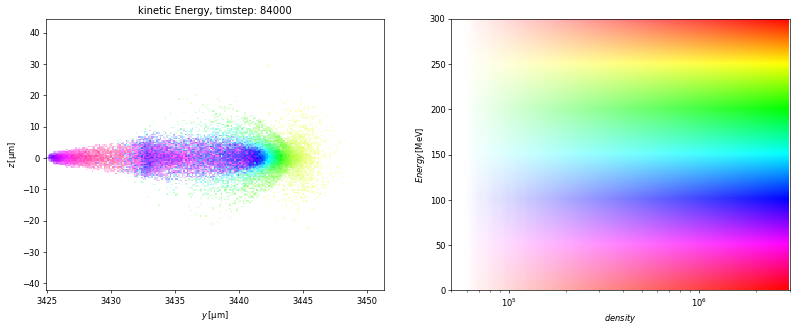

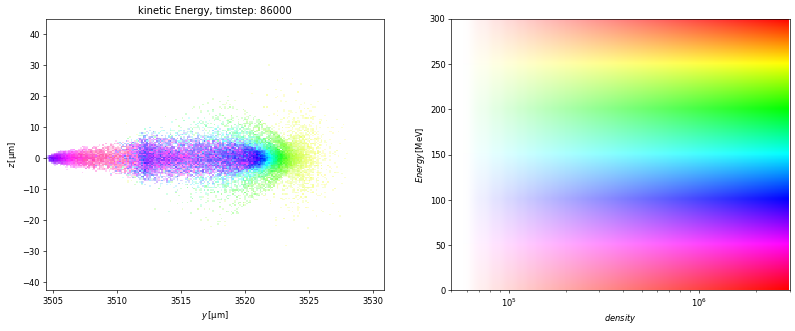

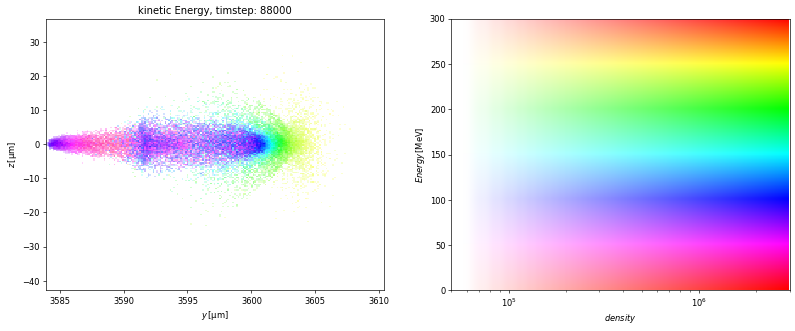

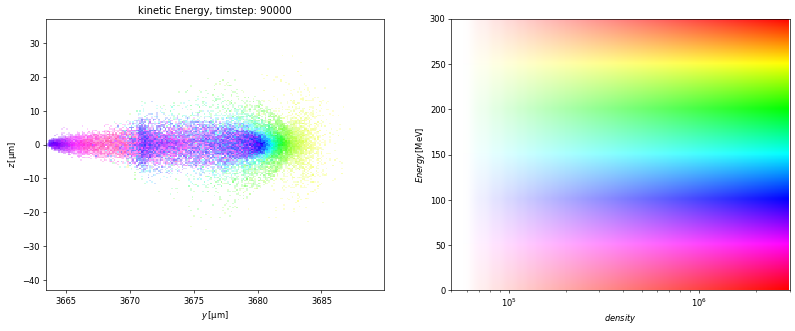

In [11]:
series = io.Series(path, io.Access.read_only)
time = range(16000, 90000+1, 2000)

vmin = 5e4
vmax = 3e6

map_h = np.linspace(1, 0, 200)
map_s = (np.log10(np.linspace(vmin, vmax, 200)) - np.log10(vmin)) / (np.log10(vmax) - np.log10(vmin))
map_hs = np.meshgrid(map_h, map_s)
map_v = np.ones((200, 200))

maphsv = np.dstack((map_hs[0], map_hs[1], map_v))
maprgb = np.transpose(hsv_to_rgb(maphsv), axes=(1,0,2))


for i, t in enumerate(time):
    particle = series.iterations[t].particles["b_all"]
    
    weight, x_pos, y_pos, z_pos, x_mom, y_mom, z_mom = particlePMD(particle)
    
    E = mom_to_E(x_mom, y_mom, z_mom)
    
    plt.figure(dpi=60, figsize=(16, 6))

    statistic, bin_y, bin_z, rest = stats.binned_statistic_2d(y_pos, z_pos, (E), statistic='mean', bins=200)
    statistic2, bin_y2, bin_z2, rest2 = stats.binned_statistic_2d(y_pos, z_pos, (weight), statistic='sum', bins=200)
    
    hue  = -(np.clip(statistic, 0, 300) / 300)+1
    saturation = (np.log10(np.clip(statistic2, vmin, vmax)) - np.log10(vmin)) / (np.log10(vmax) - np.log10(vmin))
    saturation[statistic2==0] = 0
#    print(saturation[100])
#    print(statistic2[100])
    value = np.ones_like(statistic)
    
    hsv = np.dstack((hue, saturation, value))
    rgb = np.transpose(hsv_to_rgb(hsv), axes=(1,0,2))
    

    plt.subplot(121)
    plt.imshow(rgb, extent=(bin_y[0], bin_y[-1], bin_z[0], bin_z[-1]), aspect='auto', origin="lower", interpolation='none')
    plt.xlabel("$y \, \mathrm{[\mu m]}$")
    plt.ylabel("$z \, \mathrm{[\mu m]}$")
    plt.title("kinetic Energy, timstep: {:1d}".format(t))
        
    plt.subplot(122)
    plt.imshow(maprgb, origin="lower", aspect='auto', extent=(5e4, 3e6, 0, 300))
    plt.xlabel("$density$")
    plt.ylabel("$Energy \, \mathrm{[MeV]}$")
    plt.xscale('log')

    plt.show()
#    plt.savefig(fname="temp", facecolor="white", dpi=300)
del series

# energy muss geklippt werden bei 300 MeV
# Transponieren
# Sättigung logarithmisch

In [ ]:
map_h = np.linspace(0, 1, 21)
map_s = np.linspace(0, 1, 21)
map_hs = np.meshgrid(map_h, map_s)
print(map_hs)
plt.imshow(map_hs[1]*map_hs[0], cmap='plasma', norm=LogNorm(vmin=0.01, vmax=1))
plt.colorbar()
plt.show()